# Beaver River diabase and anorthosite xenoliths inclusions in the Beaver Bay Complex Pmag compilation.

This notebook compiles data from our BRD and AX paleomagnetic samples collected in summer 2019, from the Bever Bay Complex.

The BRD samples were treated with step-wise AF demagnetization up to peak field of 130 mT. AX sample b series cores were treated with progressive thermal demagnetization, up to temperature 580 degree C with standard protocol of soaking specimens in the desired peak temperature for 20 minutes, at each heating step.



In [1]:
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from random import randrange
import random
from scipy import special
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats.mstats import mquantiles
import statsmodels.api as sm
import math
from statistics import mean
from statistics import stdev

from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
# import folium
lakes_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
Laurentia_outline = ShapelyFeature(Reader('../Data/Laurentia_shape/Laurentia.shp').geometries(),
                                ccrs.PlateCarree(), facecolor = 'none', edgecolor='black')

## BRD and AX site locations

In [3]:
AX_BD_all_site_locations = pd.read_csv('../data/GIS/AX_BRD_site_locations.csv', header = 0)
AX_BD_all_site_locations['color'] = ['red' if i.startswith('AX') else 'blue' for i in AX_BD_all_site_locations['Site']]
display(AX_BD_all_site_locations.head())
display(AX_BD_all_site_locations.tail())

Site            x            y   latitude   longitude  zone    altitude  \
0   AX1  622746.4427  5228715.472  47.200466  -91.379371   15T  242.527710   
1  AX10  661202.2988  5272149.391  47.582715  -90.856167   15T  363.645014   
2  AX11  638426.6868  5247910.416  47.369985  -91.166488   15T  226.504679   
3  AX12  631552.7768  5239089.134  47.292066  -91.260100   15T  223.971648   
4  AX13  638394.3310  5247788.142  47.368892  -91.166955   15T  228.780390   

    horiz_precision   vert_precision     heading       image name  \
0                 5                6    6.665518     img_0008.jpg   
1                 5                6    5.305441   img_0007_4.jpg   
2                 5                4  314.659668   img_0002_9.jpg   
3                 5                3  300.736206   img_0003_9.jpg   
4                10                8  136.481400   img_0008_5.jpg   

                    timedate                        notes color  
0   Thu Jul 25 15:07:07 2019           AX1 drilling holes   red  
1   Mon Jul 29 15:23:16 2019                 AX10 3 holes   red  
2   Wed Jul 31 14:51:37 2019             AX11 drill holes   red  
3   Wed Jul 31 16:37:17 2019   AX12-1 to 7 in silver bay    red  
4   Wed Jul 31 19:30:18 2019                  AX13-1 to 7   red

Site            x            y   latitude   longitude  zone    altitude  \
34  BD5  631292.7615  5238704.760  47.288661  -91.263650   15T  241.626986   
35  BD6  629140.6316  5235850.144  47.263413  -91.292925   15T  210.519075   
36  BD7  629476.4291  5236212.911  47.266610  -91.288383   15T  202.235567   
37  BD8  624473.2153  5230095.306  47.212553  -91.356198   15T  206.878052   
38  BD9  625133.7705  5231409.932  47.224252  -91.347111   15T  211.532959   

     horiz_precision   vert_precision     heading        image name  \
34                10               24  298.000000   img_0001_12.jpg   
35                10                4  296.725494   img_0002_12.jpg   
36                10                4  291.000000   img_0003_12.jpg   
37                 5                6         NaN               NaN   
38                 5                4         NaN               NaN   

                     timedate                 notes color  
34   Thu Aug  1 13:33:34 2019   BD5 1-8 drill holes  blue  
35   Sat Aug  3 15:02:34 2019                   BD6  blue  
36   Sat Aug  3 16:06:23 2019       BD7 drill holes  blue  
37   Tue Jul  7 09:37:42 2020                   BD8  blue  
38   Tue Jul  7 12:35:25 2020                   BD9  blue

In [4]:
AX_site_locations = AX_BD_all_site_locations[AX_BD_all_site_locations['color'] == 'red']
BD_site_locations = AX_BD_all_site_locations[AX_BD_all_site_locations['color'] == 'blue']

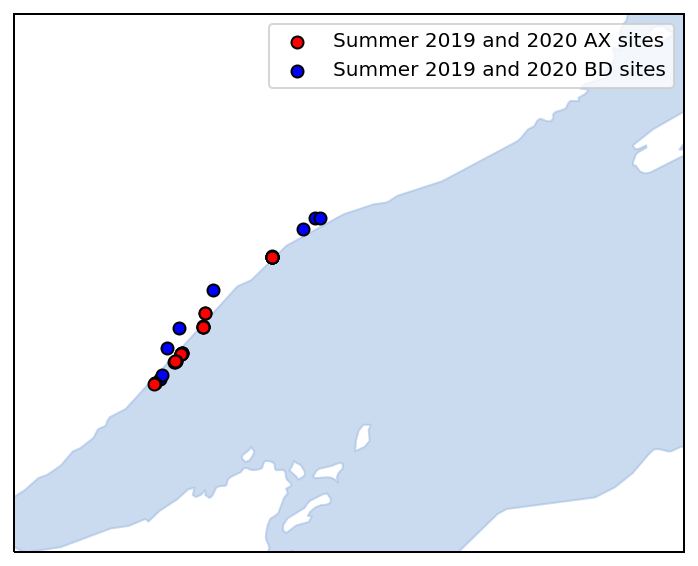

In [5]:
central_lat = 46.8
central_lon = -91
extent = [central_lon-1, central_lon+2, central_lat-0.1, central_lat+1.5]

plt.figure(1, figsize=(6,6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-90, central_latitude=50))
ax.set_extent(extent)

plt.scatter(AX_site_locations[' longitude'], 
           AX_site_locations[' latitude'],
           transform=ccrs.Geodetic(), 
           color = 'red',
           edgecolors='black',
           zorder = 101,
           label='Summer 2019 and 2020 AX sites')

plt.scatter(BD_site_locations[' longitude'], 
           BD_site_locations[' latitude'],
           transform=ccrs.Geodetic(), 
           color = 'blue',
           edgecolors='black',
           zorder = 100,
           label='Summer 2019 and 2020 BD sites')

ax.coastlines(resolution='10m')
ax.add_feature(lakes_10m, alpha=0.5)
plt.legend()
plt.show()

## Load pmag files

In [6]:
AX_BD_site_path = '../data/Pmag_new/AX_BD_Demag/sites.txt'
AX_BD_sample_path = '../data/Pmag_new/AX_BD_Demag/samples.txt'
AX_BD_specimen_path = '../data/Pmag_new/AX_BD_Demag/specimens.txt'
AX_BD_measurements_path = '../data/Pmag_new/AX_BD_Demag/measurements.txt'

AX_BD_site_data = pd.read_csv(AX_BD_site_path, sep='\t',header=1)
AX_BD_sample_data = pd.read_csv(AX_BD_sample_path, sep='\t',header=1)
AX_BD_specimen_data = pd.read_csv(AX_BD_specimen_path, sep='\t',header=1)
AX_BD_measurement_data = pd.read_csv(AX_BD_measurements_path, sep='\t',header=1)

In [7]:
display(AX_BD_site_data.head())

site            location  \
0   AX1  Beaver Bay Complex   
1   AX1  Beaver Bay Complex   
2  AX10  Beaver Bay Complex   
3  AX10  Beaver Bay Complex   
4  AX11  Beaver Bay Complex   

                                             samples  \
0    AX1-1:AX1-2:AX1-3:AX1-4:AX1-5:AX1-6:AX1-7:AX1-8   
1    AX1-1:AX1-2:AX1-3:AX1-4:AX1-5:AX1-6:AX1-7:AX1-8   
2                               AX10-1:AX10-2:AX10-3   
3                               AX10-1:AX10-2:AX10-3   
4  AX11-1:AX11-2:AX11-4:AX11-5:AX11-6:AX11-7:AX11...   

                                           specimens   age  age_high  age_low  \
0  AX1-1b:AX1-2b:AX1-3b:AX1-4b:AX1-5b:AX1-6b:AX1-...  1092   1091.83  1091.61   
1  AX1-1b:AX1-2b:AX1-3b:AX1-4b:AX1-5b:AX1-6b:AX1-...  1092   1091.83  1091.61   
2                            AX10-1b:AX10-2b:AX10-3b  1092   1091.83  1091.61   
3                            AX10-1b:AX10-2b:AX10-3b  1092   1091.83  1091.61   
4  AX11-1b:AX11-2b:AX11-4b:AX11-5b:AX11-6b:AX11-7...  1092   1091.83  1091.61   

  age_unit  dir_alpha95 dir_comp_name  ...  criteria  \
0       Ma          2.4            mt  ...    ACCEPT   
1       Ma          2.4            mt  ...    ACCEPT   
2       Ma          6.5            mt  ...    ACCEPT   
3       Ma          6.5            mt  ...    ACCEPT   
4       Ma          3.2            mt  ...    ACCEPT   

                  software_packages   citations  \
0  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
1  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
2  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
3  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
4  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   

                                        method_codes  result_quality  \
0            LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g   
1  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
2            LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g   
3  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
4            LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g   

   result_type  vgp_dm vgp_dp  vgp_lat  vgp_lon  
0            i     3.0    1.8     33.4    180.0  
1            i     3.4    2.4     37.1    193.2  
2            i     7.1    3.9     20.3    178.5  
3            i     7.6    4.4     20.8    187.0  
4            i     3.4    1.8     19.1    176.3  

[5 rows x 37 columns]

**Site BD14 and BD16 are excluded from further analysis because of large overprints, anomolously strong NRM (e-1 emu) and poor number of good fits within site**

In [8]:
# calculate paleolatitude from the inclination data
AX_BD_site_data['paleolatitude'] = pmag.plat(AX_BD_site_data['dir_inc'])

AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD14'].index)
AX_BD_site_data = AX_BD_site_data.drop(AX_BD_site_data[AX_BD_site_data['site'] == 'BD16'].index)

# filter for the site level mid temp and mid coercivity components before tilt correction 
AX_BD_site_mct = AX_BD_site_data[(AX_BD_site_data['dir_comp_name'].isin(['mc','mt'])) & (AX_BD_site_data['dir_tilt_correction'] == 0)]
    
AX_site_mct = AX_BD_site_mct[AX_BD_site_mct['site'].str.startswith('AX')]
BD_site_mct = AX_BD_site_mct[AX_BD_site_mct['site'].str.startswith('BD')]

# filter for the mid temp and mid coercivity components after tilt correction 
AX_BD_site_mct_tc = AX_BD_site_data[(AX_BD_site_data['dir_comp_name'].isin(['mc','mt'])) & (AX_BD_site_data['dir_tilt_correction'] == 100)]
AX_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('AX')]
BD_site_mct_tc = AX_BD_site_mct_tc[AX_BD_site_mct_tc['site'].str.startswith('BD')]

AX_plat = AX_site_mct_tc[['site', 'paleolatitude']].set_index('site')
BD_plat = BD_site_mct_tc[['site', 'paleolatitude']].set_index('site')

AX_plat = pd.Series(data=AX_plat['paleolatitude'], index=AX_plat.index)
BD_plat = pd.Series(data=BD_plat['paleolatitude'], index=BD_plat.index)

In [9]:
# Load AX site data
AX1 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX1']
AX2 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX2']
AX3 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX3']
AX4 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX4']
AX5 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX5']
AX6 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX6']
AX7 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX7']
AX8 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX8']
AX9 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX9']
AX10 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX10']
AX11 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX11']
AX12 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX12']
AX13 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX13']
AX14 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX14']
AX15 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX15']
AX16 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX16']
AX17 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX17']
AX18 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX18']
AX19 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX19']
AX20 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX20']
AX21 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX21']
AX22 = AX_site_mct_tc[AX_site_mct_tc['site'] == 'AX22']

# combine sites AX5-AX10 into one site since they are all from small AX in Carlton Peak
AX5_AX10 = pd.concat([AX5, AX6, AX7, AX8, AX9, AX10])

# Load BD site data
BD1 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD1']
BD2 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD2']
BD3 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD3']
BD4 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD4']
BD5 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD5']
BD6 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD6']
BD7 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD7']
BD8 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD8']
BD9 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD9']
BD10 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD10']
BD11 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD11']
BD12 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD12']
BD13 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD13']
BD14 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD14']
BD15 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD15']
BD16 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD16']
BD17 = BD_site_mct_tc[BD_site_mct_tc['site'] == 'BD17']

In [10]:
AX_BD_specimen_data.head()

specimen sample      experiments  dir_alpha95 dir_comp  dir_dec  dir_inc  \
0   AX1-1b  AX1-1              NaN          NaN      NaN      NaN      NaN   
1   AX1-1b  AX1-1  AX1-1b_LP-DIR-T          NaN       mt    287.7     57.4   
2   AX1-1b  AX1-1  AX1-1b_LP-DIR-T          NaN       mt    292.8     45.2   
3   AX1-1b  AX1-1  AX1-1b_LP-DIR-T          NaN       mt    215.7     25.5   
4   AX1-1b  AX1-1              NaN          NaN      NaN      NaN      NaN   

   dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  meas_step_unit  \
0          NaN                 NaN                  NaN  ...             NaN   
1          1.0                 9.0                100.0  ...               K   
2          1.0                 9.0                  0.0  ...               K   
3          1.0                 9.0                 -1.0  ...               K   
4          NaN                 NaN                  NaN  ...             NaN   

       analysts              instrument_codes           software_packages  \
0  Yiming Zhang                           NaN                         NaN   
1           NaN  hargrave 2019-10-25 11:42:49  pmagpy-4.2.24-1: demag_gui   
2           NaN  hargrave 2019-10-25 11:42:49  pmagpy-4.2.24-1: demag_gui   
3           NaN  hargrave 2019-10-25 11:42:49  pmagpy-4.2.24-1: demag_gui   
4  Yiming Zhang                           NaN                         NaN   

  int_corr   citations                 method_codes result_quality volume  \
0      NaN  This study                     LP-NOMAG              g    NaN   
1        u  This study  LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN   
2        u  This study   LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN   
3        u  This study       LP-DIR-T:DE-BFL:DA-DIR              g    NaN   
4      NaN  This study                     LP-NOMAG              g    NaN   

  weight  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

[5 rows x 27 columns]

In [11]:
# AX specimen data
AX_specimen_data_pre_tc = AX_BD_specimen_data[(AX_BD_specimen_data.specimen.str.startswith('AX')) & 
                                       (AX_BD_specimen_data.dir_comp.isin(['mc', 'mt'])) & 
                                       (AX_BD_specimen_data.dir_tilt_correction == 0)]

# AX specimen data tilt corrected
AX_specimen_data = AX_BD_specimen_data[(AX_BD_specimen_data.specimen.str.startswith('AX')) & 
                                       (AX_BD_specimen_data.dir_comp.isin(['mc', 'mt'])) & 
                                       (AX_BD_specimen_data.dir_tilt_correction == 100)]
# BD specimen data tilt corrected
BD_specimen_data = AX_BD_specimen_data[(AX_BD_specimen_data.specimen.str.startswith('BD')) & 
                                       (AX_BD_specimen_data.dir_comp.isin(['mc', 'mt'])) & 
                                       (AX_BD_specimen_data.dir_tilt_correction == 100)]

### combining xenoliths AX5, AX6, AX7, AX8, AX9, AX10 specimen level data

In [12]:
AX5_10specimen_data_pre_tc = AX_specimen_data_pre_tc[AX_specimen_data_pre_tc['specimen'].str.contains('AX5|AX6|AX7|AX8|AX9|AX10')]
display(AX5_10specimen_data_pre_tc.head())

AX5_10specimen_data = AX_specimen_data[AX_specimen_data['specimen'].str.contains('AX5|AX6|AX7|AX8|AX9|AX10')]
display(AX5_10specimen_data.head())

specimen  sample       experiments  dir_alpha95 dir_comp  dir_dec  \
43   AX10-1b  AX10-1  AX10-1b_LP-DIR-T          NaN       mt    282.6   
47   AX10-2b  AX10-2  AX10-2b_LP-DIR-T          NaN       mt    282.2   
53   AX10-3b  AX10-3  AX10-3b_LP-DIR-T          NaN       mt    288.6   
658   AX5-1b   AX5-1   AX5-1b_LP-DIR-T          NaN       mt    289.0   
663   AX5-3b   AX5-3   AX5-3b_LP-DIR-T          NaN       mt    292.6   

     dir_inc  dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  \
43      28.6          1.0                17.0                  0.0  ...   
47      28.9          1.0                16.0                  0.0  ...   
53      23.9          1.0                10.0                  0.0  ...   
658     30.8          1.0                17.0                  0.0  ...   
663     25.2          1.0                12.0                  0.0  ...   

     meas_step_unit  analysts              instrument_codes  \
43                K       NaN  hargrave 2019-12-02 18:20:18   
47                K       NaN  hargrave 2019-12-02 18:21:50   
53                K       NaN  hargrave 2019-12-02 18:23:19   
658               K       NaN  hargrave 2019-12-02 17:59:36   
663               K       NaN  hargrave 2019-12-02 18:01:09   

              software_packages int_corr   citations  \
43   pmagpy-4.2.24-1: demag_gui        u  This study   
47   pmagpy-4.2.24-1: demag_gui        u  This study   
53   pmagpy-4.2.24-1: demag_gui        u  This study   
658  pmagpy-4.2.24-1: demag_gui        u  This study   
663  pmagpy-4.2.24-1: demag_gui        u  This study   

                   method_codes result_quality volume weight  
43   LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN    NaN  
47   LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN    NaN  
53   LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN    NaN  
658  LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN    NaN  
663  LP-DIR-T:DE-BFL:DA-DIR-GEO              g    NaN    NaN  

[5 rows x 27 columns]

specimen  sample       experiments  dir_alpha95 dir_comp  dir_dec  \
42   AX10-1b  AX10-1  AX10-1b_LP-DIR-T          NaN       mt    276.4   
45   AX10-2b  AX10-2  AX10-2b_LP-DIR-T          NaN       mt    275.9   
54   AX10-3b  AX10-3  AX10-3b_LP-DIR-T          NaN       mt    284.0   
657   AX5-1b   AX5-1   AX5-1b_LP-DIR-T          NaN       mt    282.9   
661   AX5-3b   AX5-3   AX5-3b_LP-DIR-T          NaN       mt    288.1   

     dir_inc  dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  \
42      37.7          1.0                17.0                100.0  ...   
45      38.0          1.0                16.0                100.0  ...   
54      34.0          1.0                10.0                100.0  ...   
657     40.9          1.0                17.0                100.0  ...   
661     35.9          1.0                12.0                100.0  ...   

     meas_step_unit  analysts              instrument_codes  \
42                K       NaN  hargrave 2019-12-02 18:20:18   
45                K       NaN  hargrave 2019-12-02 18:21:50   
54                K       NaN  hargrave 2019-12-02 18:23:19   
657               K       NaN  hargrave 2019-12-02 17:59:36   
661               K       NaN  hargrave 2019-12-02 18:01:09   

              software_packages int_corr   citations  \
42   pmagpy-4.2.24-1: demag_gui        u  This study   
45   pmagpy-4.2.24-1: demag_gui        u  This study   
54   pmagpy-4.2.24-1: demag_gui        u  This study   
657  pmagpy-4.2.24-1: demag_gui        u  This study   
661  pmagpy-4.2.24-1: demag_gui        u  This study   

                    method_codes result_quality volume weight  
42   LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN    NaN  
45   LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN    NaN  
54   LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN    NaN  
657  LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN    NaN  
661  LP-DIR-T:DE-BFL:DA-DIR-TILT              g    NaN    NaN  

[5 rows x 27 columns]

In [13]:
site_AX5_10_dir_pre_tc = ipmag.fisher_mean(AX5_10specimen_data_pre_tc['dir_dec'].tolist(), AX5_10specimen_data_pre_tc['dir_inc'].tolist())
site_AX5_10_pole_pre_tc = pmag.dia_vgp(site_AX5_10_dir_pre_tc['dec'], site_AX5_10_dir_pre_tc['inc'], site_AX5_10_dir_pre_tc['alpha95'], 47.5827, -90.8562)

In [14]:
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX5'].index)
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX6'].index)
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX7'].index)
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX8'].index)
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX9'].index)
AX_site_mct = AX_site_mct.drop(AX_site_mct[AX_site_mct['site']=='AX10'].index)

AX_site_mct = AX_site_mct.append({'site': 'AX5-10', 
                        'location': 'Beaver Bay Complex', 
                        'samples': 'AX5-1:AX5-3:AX6-1:AX6-2:AX6-3:AX7-1:AX7-2:AX8-1:AX8-2:AX8-3:AX9-1:AX10-1:AX10-2:AX10-3', 
                        'specimens':'AX5-1b:AX5-3b:AX6-1b:AX6-2b:AX6-3b:AX7-1b:AX7-2b:AX8-1b:AX8-2b:AX8-3b:AX9-1b:AX10-1b:AX10-2b:AX10-3b',
                        'dir_alpha95': 2.5, 
                        'dir_comp_name': 'mt', 
                        'dir_dec': site_AX5_10_dir_pre_tc['dec'], 
                        'dir_inc': site_AX5_10_dir_pre_tc['inc'], 
                        'dir_k':site_AX5_10_dir_pre_tc['k'], 
                        'dir_n_samples': site_AX5_10_dir_pre_tc['n'], 
                        'dir_n_specimens':site_AX5_10_dir_pre_tc['n'], 
                        'dir_n_specimens_lines': site_AX5_10_dir_pre_tc['n'], 'dir_n_specimens_planes':0, 'dir_polarity':'t',
                        'dir_r': site_AX5_10_dir_pre_tc['r'], 
                        'dir_tilt_correction': 0, 
                        'lat':47.5827, 'lon':-90.8562, 
                        'analysts':'Yiming Zhang', 
                        'criteria':'ACCEPT', 
                        'software_packages':'pmagpy-4.2.24-1: demag_gui.v.3.0',
                        'citations':'This study', 
                        'method_codes':'LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM', 
                        'result_quality':'g',
                        'vgp_dm': site_AX5_10_pole_pre_tc[3], 'vgp_dp':site_AX5_10_pole_pre_tc[2], 
                        'vgp_lat':site_AX5_10_pole_pre_tc[1], 'vgp_lon':site_AX5_10_pole_pre_tc[0], 
                        'paleolatitude': pmag.plat(site_AX5_10_dir_pre_tc['inc'])}, 
                                 ignore_index=True)
AX_site_mct.tail()

site            location  \
12    AX21  Beaver Bay Complex   
13    AX22  Beaver Bay Complex   
14     AX3  Beaver Bay Complex   
15     AX4  Beaver Bay Complex   
16  AX5-10  Beaver Bay Complex   

                                              samples  \
12  AX21-1:AX21-2:AX21-3:AX21-4:AX21-5:AX21-6:AX21...   
13  AX22-10:AX22-1:AX22-2:AX22-3:AX22-5:AX22-6:AX2...   
14  AX3-10:AX3-1:AX3-2:AX3-3:AX3-4:AX3-5:AX3-6:AX3...   
15          AX4-1:AX4-2:AX4-3:AX4-4:AX4-5:AX4-7:AX4-8   
16  AX5-1:AX5-3:AX6-1:AX6-2:AX6-3:AX7-1:AX7-2:AX8-...   

                                            specimens     age  age_high  \
12  AX21-1b:AX21-2b:AX21-3b:AX21-4b:AX21-5b:AX21-6...  1092.0   1091.83   
13  AX22-10a:AX22-1a:AX22-2a:AX22-3a:AX22-5a:AX22-...  1092.0   1091.83   
14  AX3-10b:AX3-1b:AX3-2b:AX3-3b:AX3-4b:AX3-5b:AX3...  1092.0   1091.83   
15   AX4-1b:AX4-2b:AX4-3b:AX4-4b:AX4-5b:AX4-7b:AX4-8b  1092.0   1091.83   
16  AX5-1b:AX5-3b:AX6-1b:AX6-2b:AX6-3b:AX7-1b:AX7-...     NaN       NaN   

    age_low age_unit  dir_alpha95 dir_comp_name  ...  \
12  1091.61       Ma          2.0            mt  ...   
13  1091.61       Ma          3.6            mt  ...   
14  1091.61       Ma          5.9            mt  ...   
15  1091.61       Ma          6.4            mt  ...   
16      NaN      NaN          2.5            mt  ...   

                   software_packages   citations  \
12  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
13  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
14  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
15  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   
16  pmagpy-4.2.24-1: demag_gui.v.3.0  This study   

                               method_codes  result_quality  result_type  \
12  LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g            i   
13  LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g            i   
14  LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g            i   
15  LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g            i   
16  LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g          NaN   

      vgp_dm    vgp_dp    vgp_lat     vgp_lon  paleolatitude  
12  2.400000  1.400000  36.700000  170.400000      21.128721  
13  4.500000  2.800000  36.300000  177.600000      25.074505  
14  6.500000  3.500000  24.700000  174.500000      15.007936  
15  6.700000  3.500000  22.300000  169.800000      10.314105  
16  2.673992  1.473933  22.254897  178.071517      15.540162  

[5 rows x 38 columns]

In [15]:
site_AX5_10_dir = ipmag.fisher_mean(AX5_10specimen_data['dir_dec'].tolist(), AX5_10specimen_data['dir_inc'].tolist())
ipmag.print_direction_mean(site_AX5_10_dir)

site_AX5_10_pole = pmag.dia_vgp(site_AX5_10_dir['dec'], site_AX5_10_dir['inc'], site_AX5_10_dir['alpha95'], 47.5827, -90.8562)
site_AX5_10_pole

Dec: 280.7  Inc: 38.1
Number of directions in mean (n): 14
Angular radius of 95% confidence (a_95): 3.1
Precision parameter (k) estimate: 170.1


(186.52988113326091, 22.662677160796484, 2.1371608944781464, 3.614377714351952)

In [16]:
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX5'].index)
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX6'].index)
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX7'].index)
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX8'].index)
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX9'].index)
AX_site_mct_tc = AX_site_mct_tc.drop(AX_site_mct_tc[AX_site_mct_tc['site']=='AX10'].index)

AX_site_mct_tc = AX_site_mct_tc.append({'site': 'AX5-10', 
                        'location': 'Beaver Bay Complex', 
                        'samples': 'AX5-1:AX5-3:AX6-1:AX6-2:AX6-3:AX7-1:AX7-2:AX8-1:AX8-2:AX8-3:AX9-1:AX10-1:AX10-2:AX10-3', 
                        'specimens':'AX5-1b:AX5-3b:AX6-1b:AX6-2b:AX6-3b:AX7-1b:AX7-2b:AX8-1b:AX8-2b:AX8-3b:AX9-1b:AX10-1b:AX10-2b:AX10-3b',
                        'dir_alpha95': 2.5, 
                        'dir_comp_name': 'mt', 
                        'dir_dec': site_AX5_10_dir['dec'], 
                        'dir_inc': site_AX5_10_dir['inc'], 
                        'dir_k':site_AX5_10_dir['k'], 
                        'dir_n_samples': site_AX5_10_dir['n'], 
                        'dir_n_specimens':site_AX5_10_dir['n'], 
                        'dir_n_specimens_lines': site_AX5_10_dir['n'], 'dir_n_specimens_planes':0, 'dir_polarity':'t',
                        'dir_r': site_AX5_10_dir['r'], 
                        'dir_tilt_correction': 100, 
                        'lat':47.5827, 'lon':-90.8562, 
                        'analysts':'Yiming Zhang', 
                        'criteria':'ACCEPT', 
                        'software_packages':'pmagpy-4.2.24-1: demag_gui.v.3.0',
                        'citations':'This study', 
                        'method_codes':'LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM', 
                        'result_quality':'g',
                        'vgp_dm': site_AX5_10_pole[3], 'vgp_dp':site_AX5_10_pole[2], 
                        'vgp_lat':site_AX5_10_pole[1], 'vgp_lon':site_AX5_10_pole[0], 
                        'palelatitude':pmag.plat(site_AX5_10_dir['inc'])}, ignore_index=True)
AX_site_mct_tc.tail()

site            location  \
12    AX21  Beaver Bay Complex   
13    AX22  Beaver Bay Complex   
14     AX3  Beaver Bay Complex   
15     AX4  Beaver Bay Complex   
16  AX5-10  Beaver Bay Complex   

                                              samples  \
12  AX21-1:AX21-2:AX21-3:AX21-4:AX21-5:AX21-6:AX21...   
13  AX22-10:AX22-1:AX22-2:AX22-3:AX22-5:AX22-6:AX2...   
14  AX3-10:AX3-1:AX3-2:AX3-3:AX3-4:AX3-5:AX3-6:AX3...   
15          AX4-1:AX4-2:AX4-3:AX4-4:AX4-5:AX4-7:AX4-8   
16  AX5-1:AX5-3:AX6-1:AX6-2:AX6-3:AX7-1:AX7-2:AX8-...   

                                            specimens     age  age_high  \
12  AX21-1b:AX21-2b:AX21-3b:AX21-4b:AX21-5b:AX21-6...  1092.0   1091.83   
13  AX22-10a:AX22-1a:AX22-2a:AX22-3a:AX22-5a:AX22-...  1092.0   1091.83   
14  AX3-10b:AX3-1b:AX3-2b:AX3-3b:AX3-4b:AX3-5b:AX3...  1092.0   1091.83   
15   AX4-1b:AX4-2b:AX4-3b:AX4-4b:AX4-5b:AX4-7b:AX4-8b  1092.0   1091.83   
16  AX5-1b:AX5-3b:AX6-1b:AX6-2b:AX6-3b:AX7-1b:AX7-...     NaN       NaN   

    age_low age_unit  dir_alpha95 dir_comp_name  ...   citations  \
12  1091.61       Ma          2.0            mt  ...  This study   
13  1091.61       Ma          3.6            mt  ...  This study   
14  1091.61       Ma          5.9            mt  ...  This study   
15  1091.61       Ma          6.4            mt  ...  This study   
16      NaN      NaN          2.5            mt  ...  This study   

                                         method_codes  result_quality  \
12  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
13  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
14  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
15  LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...               g   
16            LP-DIR-T:DE-BFL:DA-DIR-GEO:LP-DC4:DE-FM               g   

    result_type    vgp_dm    vgp_dp    vgp_lat     vgp_lon  paleolatitude  \
12            i  2.700000  1.800000  42.100000  181.700000      31.238843   
13            i  5.200000  3.700000  41.000000  191.100000      36.240395   
14            i  7.000000  4.200000  25.900000  183.700000      21.759154   
15            i  7.100000  4.000000  24.400000  177.200000      16.535010   
16          NaN  3.614378  2.137161  22.662677  186.529881            NaN   

    palelatitude  
12           NaN  
13           NaN  
14           NaN  
15           NaN  
16     21.374986  

[5 rows x 39 columns]

In [17]:
# Load specimen data for common mean test
BD1_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD1-']
BD2_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD2-']
BD3_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD3-']
BD4_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD4-']
BD5_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD5-']
BD6_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD6-']
BD7_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD7-']
BD8_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD8-']
BD9_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:4]=='BD9-']
BD10_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD10-']
BD11_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD11-']
BD12_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD12-']
BD13_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD13-']
BD14_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD14-']
BD15_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD15-']
BD16_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD16-']
BD17_specs = BD_specimen_data[BD_specimen_data['specimen'].str[:5]=='BD17-']

BD1_blocks = ipmag.make_di_block(BD1_specs.dir_dec.tolist(), BD1_specs.dir_inc.tolist())
BD2_blocks = ipmag.make_di_block(BD2_specs.dir_dec.tolist(), BD2_specs.dir_inc.tolist())
BD3_blocks = ipmag.make_di_block(BD3_specs.dir_dec.tolist(), BD3_specs.dir_inc.tolist())
BD4_blocks = ipmag.make_di_block(BD4_specs.dir_dec.tolist(), BD4_specs.dir_inc.tolist())
BD5_blocks = ipmag.make_di_block(BD5_specs.dir_dec.tolist(), BD5_specs.dir_inc.tolist())
BD6_blocks = ipmag.make_di_block(BD6_specs.dir_dec.tolist(), BD6_specs.dir_inc.tolist())
BD7_blocks = ipmag.make_di_block(BD7_specs.dir_dec.tolist(), BD7_specs.dir_inc.tolist())
BD10_blocks = ipmag.make_di_block(BD10_specs.dir_dec.tolist(), BD10_specs.dir_inc.tolist())

AX1_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX1-']
AX2_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX2-']
AX3_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX3-']
AX4_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX4-']
AX5_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX5-']
AX6_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX6-']
AX7_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX7-']
AX8_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX8-']
AX9_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:4]=='AX9-']
AX10_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX10-']
AX11_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX11-']
AX12_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX12-']
AX13_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX13-']
AX14_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX14-']
AX15_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX15-']
AX16_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX16-']
AX17_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX17-']
AX18_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX18-']
AX19_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX19-']
AX20_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX20-']
AX21_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX21-']
AX22_specs = AX_specimen_data[AX_specimen_data['specimen'].str[:5]=='AX22-']

AX1_blocks = ipmag.make_di_block(AX1_specs.dir_dec.tolist(), AX1_specs.dir_inc.tolist())
AX2_blocks = ipmag.make_di_block(AX2_specs.dir_dec.tolist(), AX2_specs.dir_inc.tolist())
AX3_blocks = ipmag.make_di_block(AX3_specs.dir_dec.tolist(), AX3_specs.dir_inc.tolist())
AX4_blocks = ipmag.make_di_block(AX4_specs.dir_dec.tolist(), AX4_specs.dir_inc.tolist())
AX5_blocks = ipmag.make_di_block(AX5_specs.dir_dec.tolist(), AX5_specs.dir_inc.tolist())
AX6_blocks = ipmag.make_di_block(AX6_specs.dir_dec.tolist(), AX6_specs.dir_inc.tolist())
AX7_blocks = ipmag.make_di_block(AX7_specs.dir_dec.tolist(), AX7_specs.dir_inc.tolist())
AX8_blocks = ipmag.make_di_block(AX8_specs.dir_dec.tolist(), AX8_specs.dir_inc.tolist())
AX10_blocks = ipmag.make_di_block(AX10_specs.dir_dec.tolist(), AX10_specs.dir_inc.tolist())

# make site 5 to 10 dec and inc into one same block
AX5_10_blocks = ipmag.make_di_block(AX5_10specimen_data['dir_dec'].tolist(), AX5_10specimen_data['dir_inc'].tolist())

AX11_blocks = ipmag.make_di_block(AX11_specs.dir_dec.tolist(), AX11_specs.dir_inc.tolist())
AX12_blocks = ipmag.make_di_block(AX12_specs.dir_dec.tolist(), AX12_specs.dir_inc.tolist())
AX13_blocks = ipmag.make_di_block(AX13_specs.dir_dec.tolist(), AX13_specs.dir_inc.tolist())
AX14_blocks = ipmag.make_di_block(AX14_specs.dir_dec.tolist(), AX14_specs.dir_inc.tolist())
AX15_blocks = ipmag.make_di_block(AX15_specs.dir_dec.tolist(), AX15_specs.dir_inc.tolist())
AX16_blocks = ipmag.make_di_block(AX16_specs.dir_dec.tolist(), AX16_specs.dir_inc.tolist())
AX17_blocks = ipmag.make_di_block(AX17_specs.dir_dec.tolist(), AX17_specs.dir_inc.tolist())
AX18_blocks = ipmag.make_di_block(AX18_specs.dir_dec.tolist(), AX18_specs.dir_inc.tolist())
AX19_blocks = ipmag.make_di_block(AX19_specs.dir_dec.tolist(), AX19_specs.dir_inc.tolist())
AX20_blocks = ipmag.make_di_block(AX20_specs.dir_dec.tolist(), AX20_specs.dir_inc.tolist())
AX21_blocks = ipmag.make_di_block(AX21_specs.dir_dec.tolist(), AX21_specs.dir_inc.tolist())
AX22_blocks = ipmag.make_di_block(AX22_specs.dir_dec.tolist(), AX22_specs.dir_inc.tolist())

## Plot pmag directions and VGPs

In [18]:
# mean direction pre tilt correction
AX_site_mct_mean = ipmag.fisher_mean(AX_site_mct['dir_dec'].tolist(), AX_site_mct['dir_inc'].tolist())
BD_site_mct_mean = ipmag.fisher_mean(BD_site_mct['dir_dec'].tolist(), BD_site_mct['dir_inc'].tolist())

# mean direction post tilt correction
AX_site_mct_tc_mean = ipmag.fisher_mean(AX_site_mct_tc['dir_dec'].tolist(), AX_site_mct_tc['dir_inc'].tolist())
BD_site_mct_tc_mean = ipmag.fisher_mean(BD_site_mct_tc['dir_dec'].tolist(), BD_site_mct_tc['dir_inc'].tolist())


ipmag.print_direction_mean(AX_site_mct_mean)
ipmag.print_direction_mean(BD_site_mct_mean)
print()
ipmag.print_direction_mean(AX_site_mct_tc_mean)
ipmag.print_direction_mean(BD_site_mct_tc_mean)

Dec: 289.3  Inc: 36.5
Number of directions in mean (n): 17
Angular radius of 95% confidence (a_95): 4.9
Precision parameter (k) estimate: 55.0
Dec: 291.0  Inc: 35.7
Number of directions in mean (n): 15
Angular radius of 95% confidence (a_95): 6.9
Precision parameter (k) estimate: 31.7

Dec: 284.5  Inc: 48.2
Number of directions in mean (n): 17
Angular radius of 95% confidence (a_95): 5.0
Precision parameter (k) estimate: 51.6
Dec: 286.9  Inc: 47.7
Number of directions in mean (n): 15
Angular radius of 95% confidence (a_95): 7.0
Precision parameter (k) estimate: 30.5


In [19]:
# mean VGP pre tilt correction
AX_site_vgp_mean = ipmag.fisher_mean(AX_site_mct['vgp_lon'].tolist(), AX_site_mct['vgp_lat'].tolist())
BD_site_vgp_mean = ipmag.fisher_mean(BD_site_mct['vgp_lon'].tolist(), BD_site_mct['vgp_lat'].tolist())

# mean VGP post tilt correction
AX_site_vgp_tc_mean = ipmag.fisher_mean(AX_site_mct_tc['vgp_lon'].tolist(), AX_site_mct_tc['vgp_lat'].tolist())
BD_site_vgp_tc_mean = ipmag.fisher_mean(BD_site_mct_tc['vgp_lon'].tolist(), BD_site_mct_tc['vgp_lat'].tolist())


ipmag.print_pole_mean(AX_site_vgp_mean)
ipmag.print_pole_mean(BD_site_vgp_mean)
print()
ipmag.print_pole_mean(AX_site_vgp_tc_mean)
ipmag.print_pole_mean(BD_site_vgp_tc_mean)

Plon: 179.6  Plat: 28.0
Number of directions in mean (n): 17
Angular radius of 95% confidence (A_95): 4.3
Precision parameter (k) estimate: 70.6
Plon: 178.2  Plat: 29.0
Number of directions in mean (n): 15
Angular radius of 95% confidence (A_95): 5.2
Precision parameter (k) estimate: 55.3

Plon: 190.8  Plat: 30.9
Number of directions in mean (n): 17
Angular radius of 95% confidence (A_95): 5.2
Precision parameter (k) estimate: 48.5
Plon: 189.5  Plat: 32.5
Number of directions in mean (n): 15
Angular radius of 95% confidence (A_95): 6.3
Precision parameter (k) estimate: 37.4


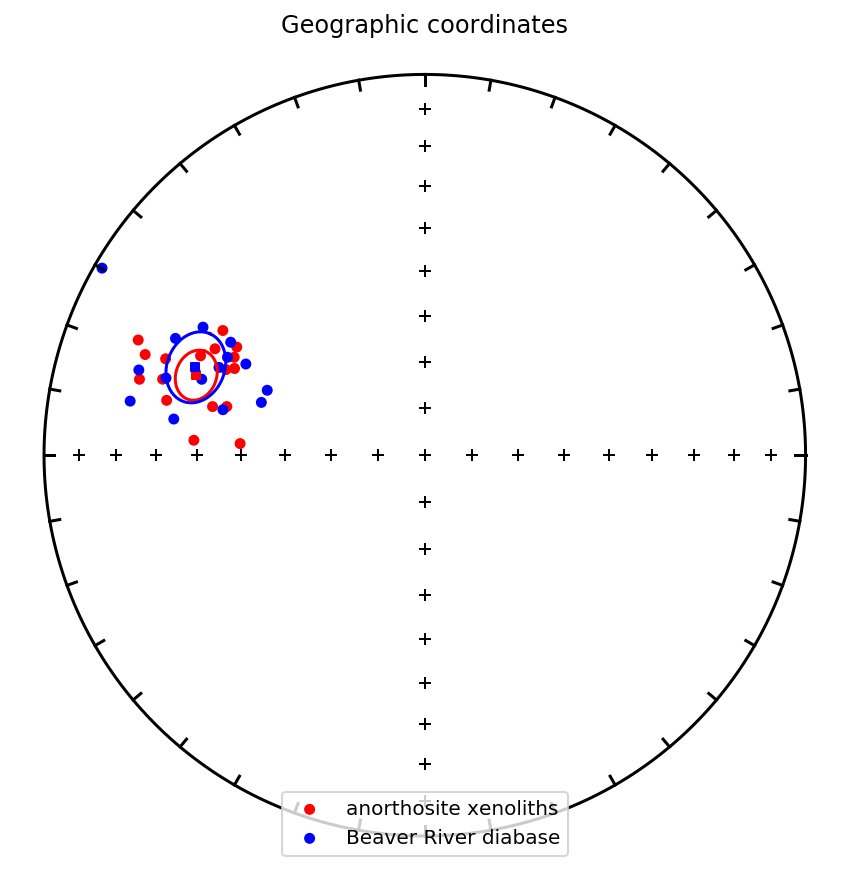

In [20]:
# pre tilt correction site mean directions
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(AX_site_mct['dir_dec'].tolist(), AX_site_mct['dir_inc'].tolist(), color = 'red', label = 'anorthosite xenoliths')
ipmag.plot_di(BD_site_mct['dir_dec'].tolist(), BD_site_mct['dir_inc'].tolist(), color = 'blue', label = 'Beaver River diabase')

ipmag.plot_di_mean(AX_site_mct_mean['dec'],AX_site_mct_mean['inc'],AX_site_mct_mean['alpha95'],
                   color='red', marker = 's')
ipmag.plot_di_mean(BD_site_mct_mean['dec'],BD_site_mct_mean['inc'],BD_site_mct_mean['alpha95'],
                   color='blue', marker = 's')
plt.legend(loc=8)
plt.title('Geographic coordinates')
# plt.savefig('code_output/pmag/AX_BD_site_mean_directions_gc.pdf', bbox_inches='tight')
plt.show()

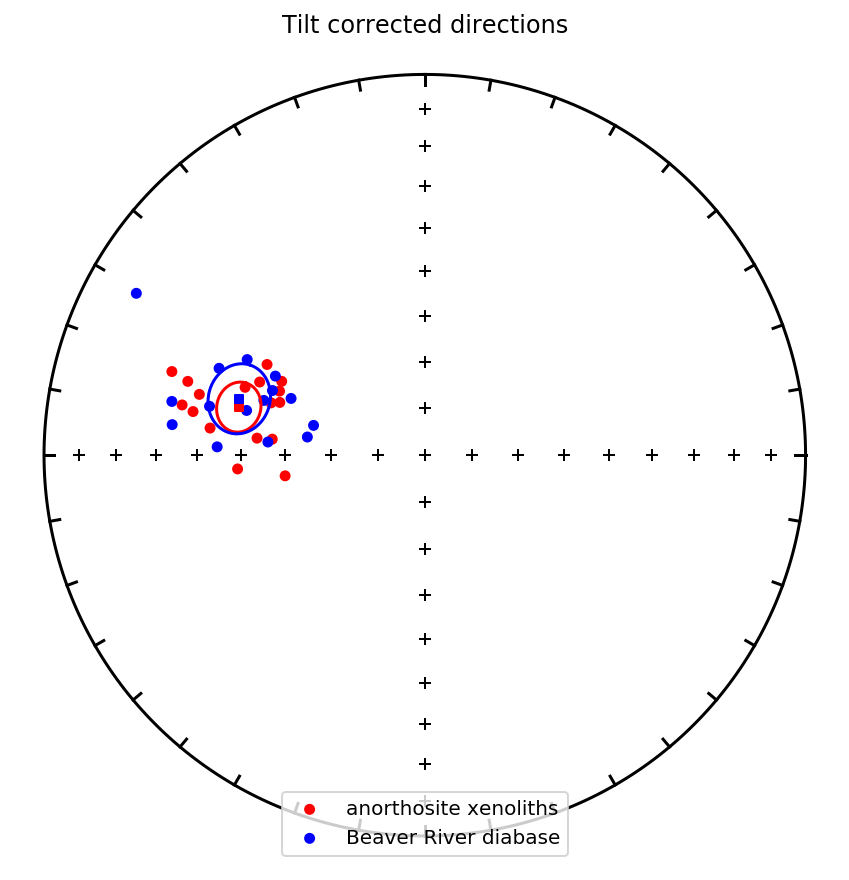

In [21]:
# post tilt correction site mean directions
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(AX_site_mct_tc['dir_dec'].tolist(), AX_site_mct_tc['dir_inc'].tolist(), color = 'red', label = 'anorthosite xenoliths')
ipmag.plot_di(BD_site_mct_tc['dir_dec'].tolist(), BD_site_mct_tc['dir_inc'].tolist(), color = 'blue', label = 'Beaver River diabase')

ipmag.plot_di_mean(AX_site_mct_tc_mean['dec'],AX_site_mct_tc_mean['inc'],AX_site_mct_tc_mean['alpha95'],
                   color='red', marker = 's')
ipmag.plot_di_mean(BD_site_mct_tc_mean['dec'],BD_site_mct_tc_mean['inc'],BD_site_mct_tc_mean['alpha95'],
                   color='blue', marker = 's')
plt.legend(loc=8)
plt.title('Tilt corrected directions')
# plt.savefig('code_output/pmag/AX_BD_site_mean_directions_tc.pdf', bbox_inches='tight')
plt.show()

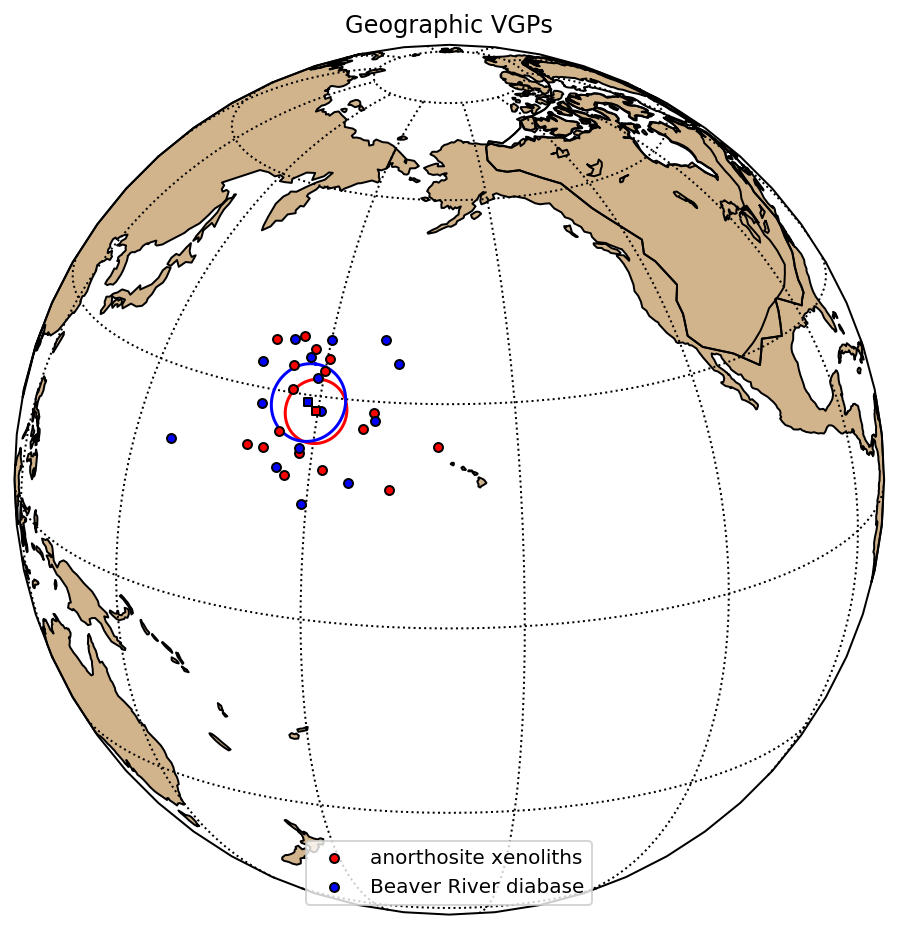

In [22]:
# pre tilt correction VGPs
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
map_axis.add_feature(Laurentia_outline)

ipmag.plot_vgp(map_axis, AX_site_mct['vgp_lon'].tolist(), AX_site_mct['vgp_lat'].tolist(), 
               color = 'red', label = 'anorthosite xenoliths')
ipmag.plot_vgp(map_axis, BD_site_mct['vgp_lon'].tolist(), BD_site_mct['vgp_lat'].tolist(), 
               color = 'blue', label = 'Beaver River diabase')

ipmag.plot_pole(map_axis, AX_site_vgp_mean['dec'], AX_site_vgp_mean['inc'], AX_site_vgp_mean['alpha95'], 
                color = 'red', marker = 's')
ipmag.plot_pole(map_axis, BD_site_vgp_mean['dec'], BD_site_vgp_mean['inc'], BD_site_vgp_mean['alpha95'], 
                color = 'blue', marker = 's')
plt.legend(loc=8)
plt.title('Geographic VGPs')
# plt.savefig('code_output/pmag/AX_BD_site_VGPs.pdf')
plt.show()

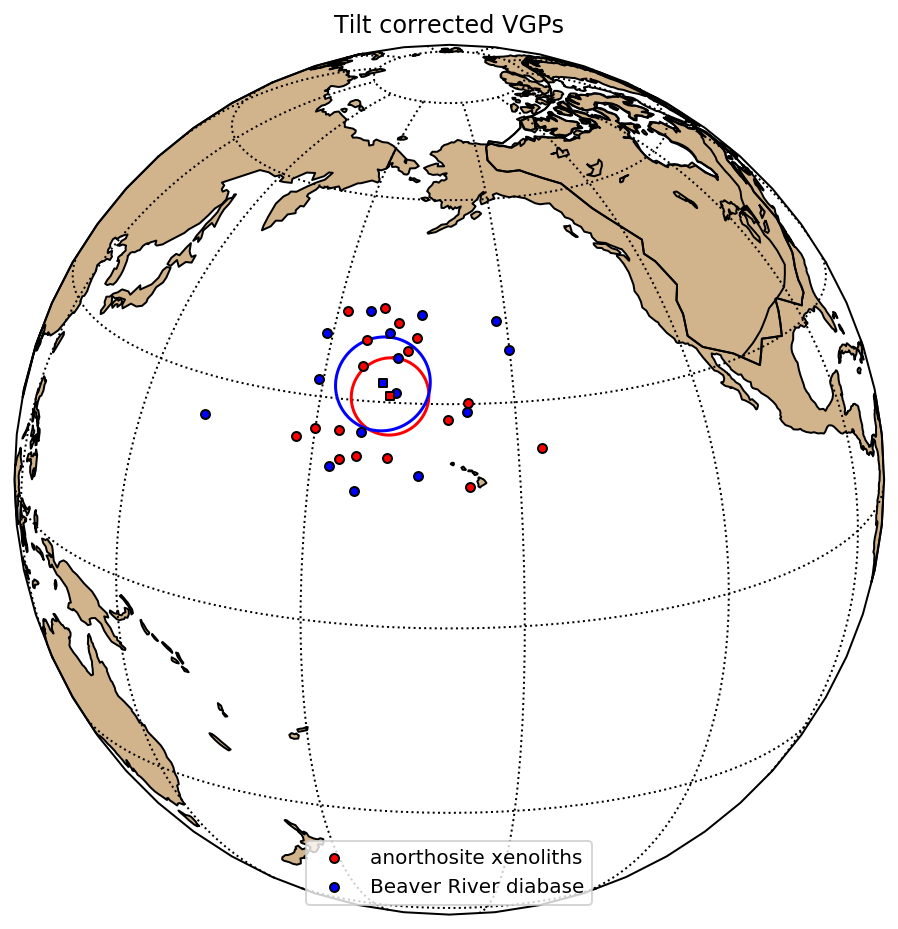

In [23]:
# post tilt correction VGPs
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
map_axis.add_feature(Laurentia_outline)

ipmag.plot_vgp(map_axis, AX_site_mct_tc['vgp_lon'].tolist(), AX_site_mct_tc['vgp_lat'].tolist(), 
               color = 'red', label = 'anorthosite xenoliths')
ipmag.plot_vgp(map_axis, BD_site_mct_tc['vgp_lon'].tolist(), BD_site_mct_tc['vgp_lat'].tolist(), 
               color = 'blue', label = 'Beaver River diabase')

ipmag.plot_pole(map_axis, AX_site_vgp_tc_mean['dec'], AX_site_vgp_tc_mean['inc'], AX_site_vgp_tc_mean['alpha95'], 
                color = 'red', marker = 's')
ipmag.plot_pole(map_axis, BD_site_vgp_tc_mean['dec'], BD_site_vgp_tc_mean['inc'], BD_site_vgp_tc_mean['alpha95'], 
                color = 'blue', marker = 's')

plt.legend(loc=8)
plt.title('Tilt corrected VGPs')
# plt.savefig('code_output/pmag/AX_BD_site_VGPs_tc.pdf')
plt.show()

In [ ]:
m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))


ipmag.plot_pole(m, AX_site_vgp_mean['dec'], AX_site_vgp_mean['inc'], AX_site_vgp_mean['alpha95'], marker = 'D', color = 'red', label = 'Anorthosite gc')
ipmag.plot_pole(m, BD_site_vgp_mean['dec'], BD_site_vgp_mean['inc'], BD_site_vgp_mean['alpha95'], marker = 'D', color = 'blue', label = 'Diabase gc')
ipmag.plot_pole(m, AX_site_vgp_tc_mean['dec'], AX_site_vgp_tc_mean['inc'], AX_site_vgp_tc_mean['alpha95'], 
                marker = 'D', color = 'red', label = 'Anorthosite tc')
ipmag.plot_pole(m, BD_site_vgp_tc_mean['dec'], BD_site_vgp_tc_mean['inc'], BD_site_vgp_tc_mean['alpha95'], 
                marker = 'D', color = 'blue', label = 'Diabase tc')

plt.legend(loc=8)
plt.title('Diabase and anorthosite VGPs')
plt.savefig('code_output/pmag/AX_BD_site_poles.pdf')
plt.show()

## Plot AX and BD VGPs in context of interted MCR poles

The inverted Keweenawan APWP pole positions are from:
Swanson-Hysell, N. L., Ramezani, J., Fairchild, L. M., & Rose, I. R. (2019). Failed rifting and fast drifting: Midcontinent rift development, Laurentia’s rapid motion and the driver of Grenvillian orogenesis. Bulletin, 131(5-6), 913-940.

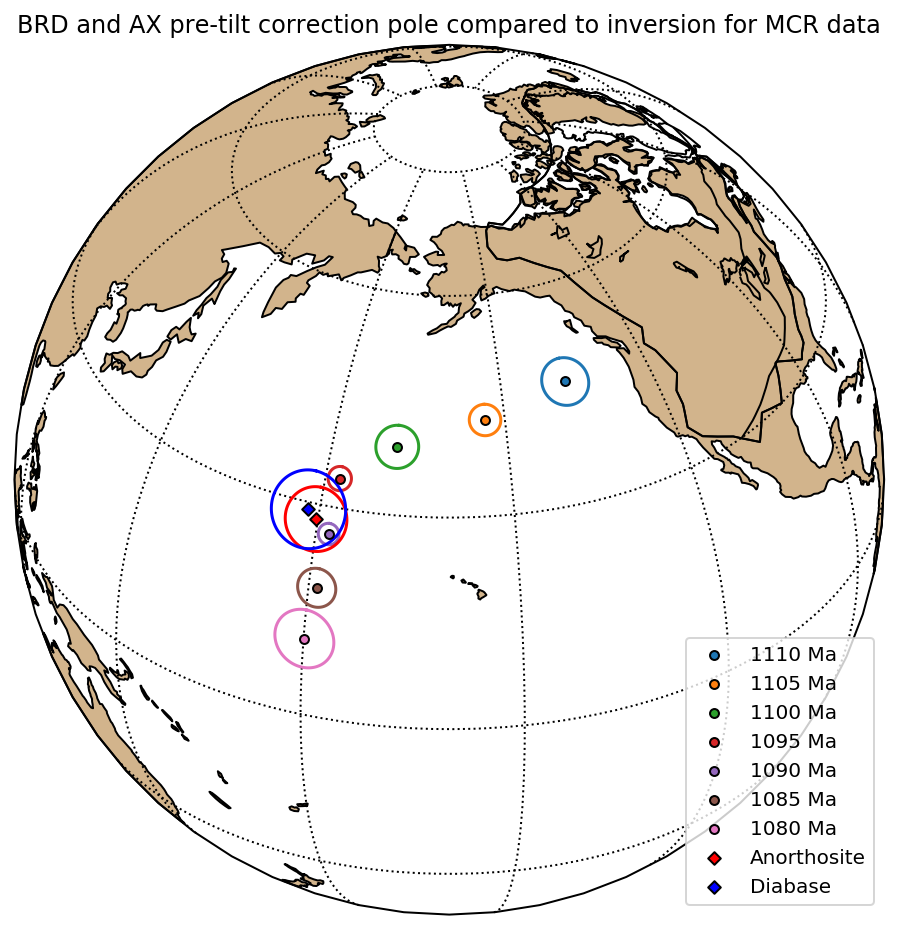

In [24]:
one_Euler_pole_lon = np.loadtxt('../Data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../Data/mcplates_results/pole_lat_positions_2_true.txt')

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color='C0',label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color='C1',label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color='C2',label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color='C3',label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color='C4',label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color='C5',label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color='C6',label='1080 Ma')

ipmag.plot_pole(m, AX_site_vgp_mean['dec'], AX_site_vgp_mean['inc'], AX_site_vgp_mean['alpha95'], marker = 'D', color = 'red', label = 'Anorthosite')
ipmag.plot_pole(m, BD_site_vgp_mean['dec'], BD_site_vgp_mean['inc'], BD_site_vgp_mean['alpha95'], marker = 'D', color = 'blue', label = 'Diabase')

plt.legend(loc = 4)
plt.title('BRD and AX pre-tilt correction pole compared to inversion for MCR data')
# plt.savefig('code_output/pmag/BRD_AX_Keweenawan_2e_true.pdf')
plt.show()

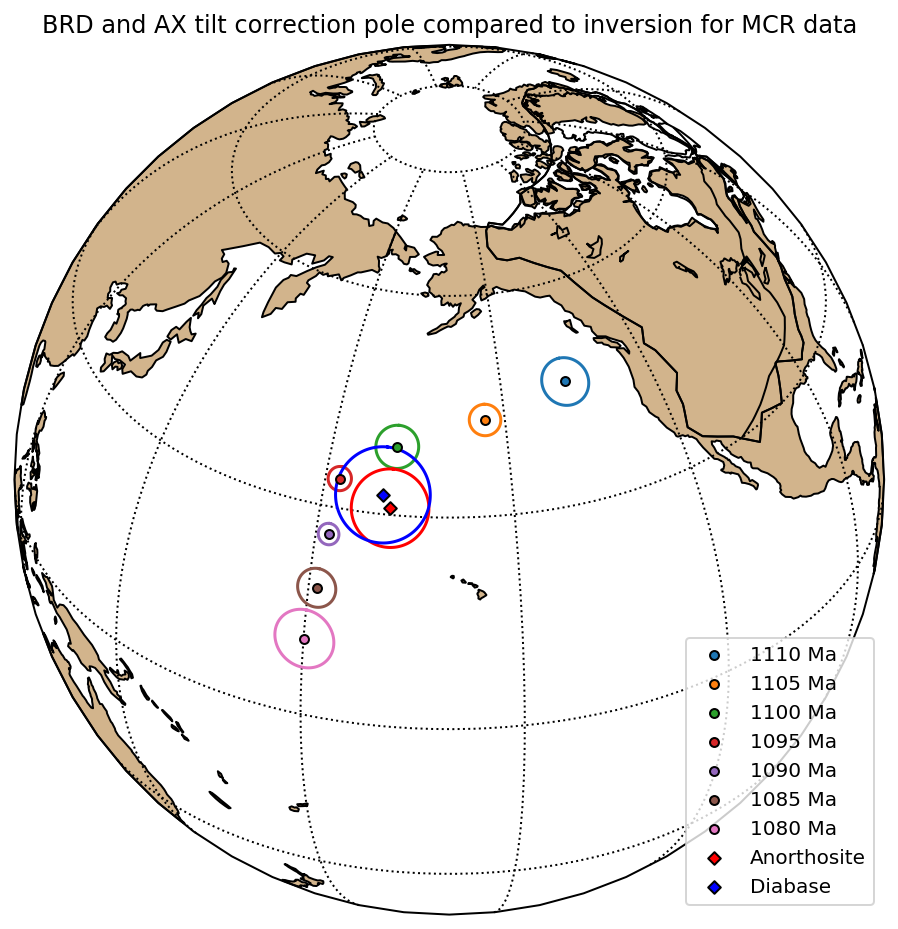

In [25]:
one_Euler_pole_lon = np.loadtxt('../Data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../Data/mcplates_results/pole_lat_positions_2_true.txt')

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color='C0',label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color='C1',label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color='C2',label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color='C3',label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color='C4',label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color='C5',label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color='C6',label='1080 Ma')

ipmag.plot_pole(m, AX_site_vgp_tc_mean['dec'], AX_site_vgp_tc_mean['inc'], AX_site_vgp_tc_mean['alpha95'], marker = 'D', color = 'red', label = 'Anorthosite')
ipmag.plot_pole(m, BD_site_vgp_tc_mean['dec'], BD_site_vgp_tc_mean['inc'], BD_site_vgp_tc_mean['alpha95'], marker = 'D', color = 'blue', label = 'Diabase')

plt.legend(loc = 4)
plt.title('BRD and AX tilt corrected poles compared to inverted Keweenawan Track')
# plt.savefig('code_output/pmag/BRD_AX_pole_Keweenawan_2e_true_tc.pdf')
plt.show()

## Compare diabase and anorthosite thermal demagnetization spectrum

In [26]:
measurements = pd.read_csv('../data/Pmag_new/AX_BD_Demag/measurements.txt', sep='\t', header = 1)
AX_demag_measurements = measurements[measurements['specimen'].str.contains('AX')] 
BD_demag_measurements = measurements[measurements['specimen'].str.contains('BD')] 
BD_demag_measurements = BD_demag_measurements[~BD_demag_measurements['experiment'].str.contains('AF')]

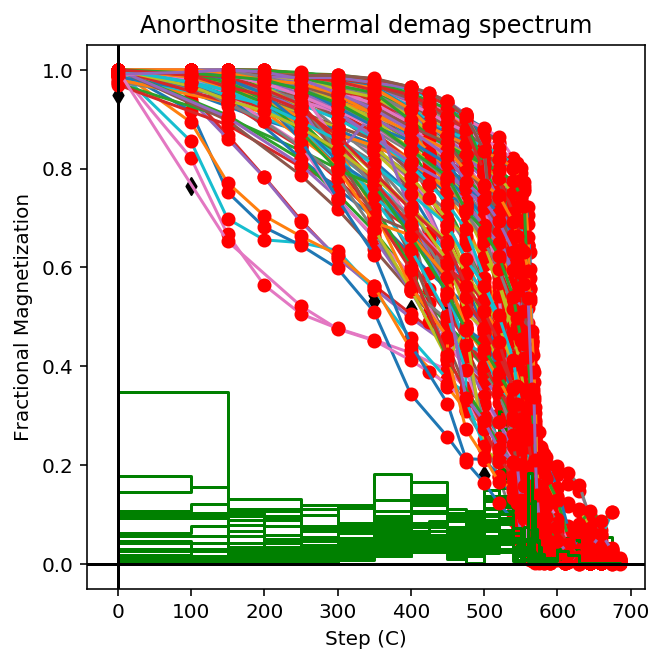

In [27]:
ipmag.plot_dmag(AX_demag_measurements, dmag_key='treat_temp', intensity = 'magn_moment', norm=True, quality=True)
plt.title('Anorthosite thermal demag spectrum');

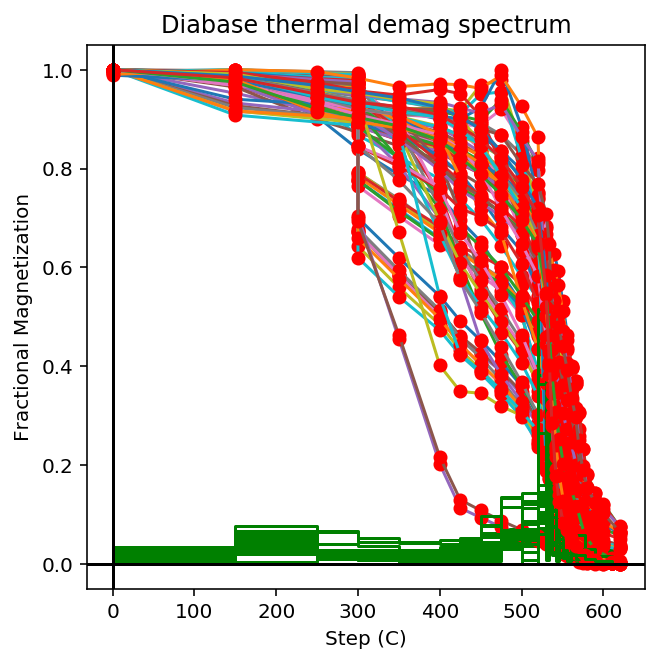

In [28]:
ipmag.plot_dmag(BD_demag_measurements, dmag_key='treat_temp', intensity = 'magn_moment', norm=True, quality=True)
plt.title('Diabase thermal demag spectrum');

## Compare the fit bounds for diabase and anorthosite specimes

In [29]:
redo_file = pd.read_csv('../data/Pmag_new/AX_BD_demag/demag_gui.redo', sep='\t', header=None)
redo_file[2] = redo_file[2] - 273
redo_file[3] = redo_file[3] - 273
redo_file = redo_file[redo_file[4] == 'mt']
redo_file = redo_file[redo_file[6] == 'g']
redo_file.head()

0       1      2      3   4        5  6
0          AX1-1b  DE-BFL  520.0  570.0  mt  #4ED740  g
1  current_AX1-2b  DE-BFL  475.0  570.0  mt  #4ED740  g
2          AX1-3b  DE-BFL  500.0  570.0  mt  #4ED740  g
3          AX1-4b  DE-BFL  450.0  570.0  mt  #4ED740  g
4          AX1-5b  DE-BFL  500.0  570.0  mt  #4ED740  g

In [30]:
redo_file['unit'] = ['AX' if 'AX' in i else 'BD' for i in redo_file[0]]
redo_file.head()

0       1      2      3   4        5  6 unit
0          AX1-1b  DE-BFL  520.0  570.0  mt  #4ED740  g   AX
1  current_AX1-2b  DE-BFL  475.0  570.0  mt  #4ED740  g   AX
2          AX1-3b  DE-BFL  500.0  570.0  mt  #4ED740  g   AX
3          AX1-4b  DE-BFL  450.0  570.0  mt  #4ED740  g   AX
4          AX1-5b  DE-BFL  500.0  570.0  mt  #4ED740  g   AX

In [31]:
AX_redo_file = redo_file[redo_file['unit'] == 'AX']
BD_redo_file = redo_file[redo_file['unit'] == 'BD']

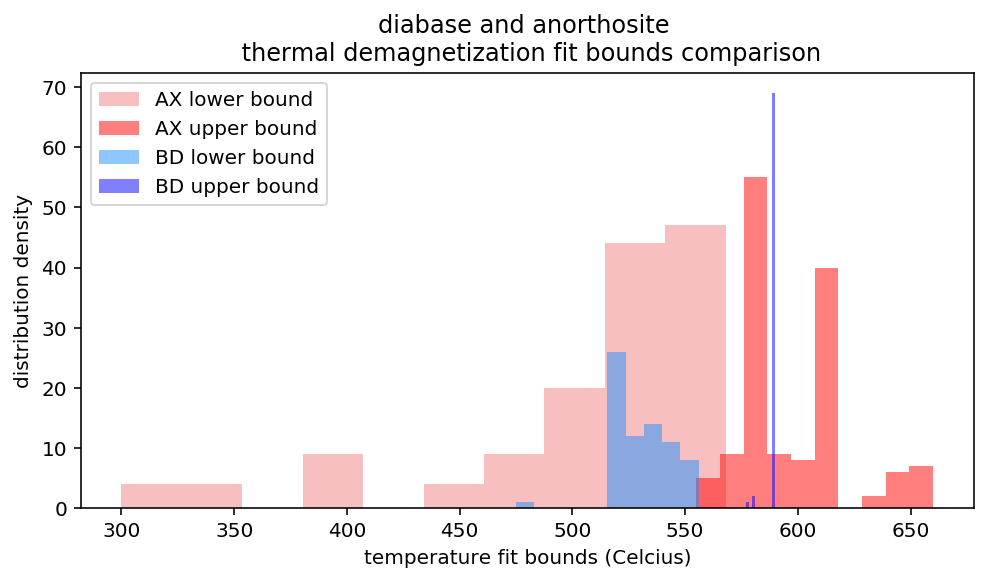

In [32]:
plt.figure(figsize = (8,4,))

plt.hist(AX_redo_file[2].tolist(), bins = 10, color = 'lightcoral', alpha = 0.5, density=False, label = 'AX lower bound')
plt.hist(AX_redo_file[3].tolist(), bins = 10, color = 'red', alpha = 0.5, density=False, label = 'AX upper bound')

plt.hist(BD_redo_file[2].tolist(), bins = 10, color = 'dodgerblue', alpha = 0.5, density=False, label = 'BD lower bound')
plt.hist(BD_redo_file[3].tolist(), bins = 10, color = 'blue', alpha = 0.5, density=False, label = 'BD upper bound')

plt.xlabel('temperature fit bounds (Celcius)')
plt.ylabel('distribution density')
plt.title('diabase and anorthosite \n thermal demagnetization fit bounds comparison')
plt.legend()
plt.show()

## Proportion of anorthosite and diabase that have a lower fit bound >= 500 degree C

In [33]:
sum(AX_redo_file[2] >= 500)/AX_redo_file.shape[0]

0.7872340425531915

In [34]:
sum(BD_redo_file[2] >= 500)/BD_redo_file.shape[0]

0.9861111111111112

## Export pmag tables

In [35]:
AX_data_mt_pre_tilt = AX_site_mct[['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dir_k','dir_alpha95','vgp_lat','vgp_lon']]

In [36]:
AX_data_mt_post_tilt = AX_site_mct_tc[['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dir_k','dir_alpha95','vgp_lat','vgp_lon']]

In [37]:
BD_data_mc_pre_tilt = BD_site_mct[['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dir_k','dir_alpha95','vgp_lat','vgp_lon']]

In [38]:
BD_data_mc_post_tilt = BD_site_mct_tc[['site', 'lat', 'lon','dir_n_samples','dir_dec','dir_inc','dir_k','dir_alpha95','vgp_lat','vgp_lon']]

In [39]:
# BD_data_mc_pre_tilt.to_csv('../data/Pmag_new/BD_pmag_pre_tilt.csv')
# BD_data_mc_post_tilt.to_csv('../data/Pmag_new/BD_pmag_post_tilt.csv')
# AX_data_mt_pre_tilt.to_csv('../data/Pmag_new/AX_pmag_pre_tilt.csv')
# AX_data_mt_post_tilt.to_csv('../data/Pmag_new/AX_pmag_post_tilt.csv')

## Using only tilt corrected directions from now on

## Common mean test

This common mean test studies each pair of AX and BRD sites we sampled. We would like to see whether each AX has remanence direction that agree with its own in situ host BRD body. 

Here, pair means AX and BD site taken from same single outcrop, and are in contact with each other.

The pairs are: 
- BD1-AX1-AX2
- BD2-AX3-AX4-AX5-AX6-AX7-AX8-AX9-AX10
- BD3-AX11-AX13
- BD4-AX12-AX14
- BD5-AX15-AX16-AX17-AX18
- BD6-AX19
- BD7-AX20-AX21
- BD10-AX22

Other BD sites, BD8, BD9, BD11, BD12, BD13, BD14, BD15, BD16, BD17 are single standing BD outcrops. 

### Group 1: AX1 and BD1

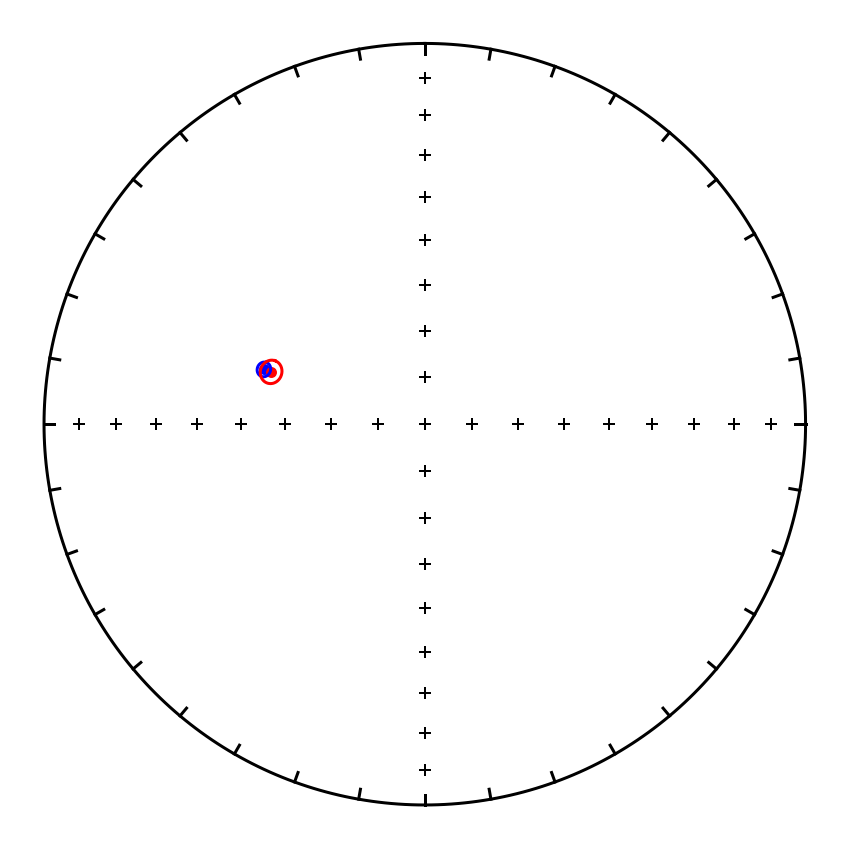

In [40]:
# AX1 and BD1
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD1.dir_dec), float(BD1.dir_inc), float(BD1.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX1.dir_dec), float(AX1.dir_inc), float(AX1.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair1.pdf')
plt.show()

In [41]:
ipmag.common_mean_watson(BD1_blocks, AX1_blocks)

Results of Watson V test: 

Watson's V:           2.9
Critical value of V:  6.8
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.8
Critical angle for M&M1990:   2.7
The McFadden and McElhinny (1990) classification for
this test is: 'A'


(1, 1.7535100122523162, 2.712031563043578)

In [42]:
ipmag.common_mean_watson(BD1_blocks, AX2_blocks)

Results of Watson V test: 

Watson's V:           60.6
Critical value of V:  7.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 13.2
Critical angle for M&M1990:   4.5



(0, 13.15589729608161, 4.465572265984006)

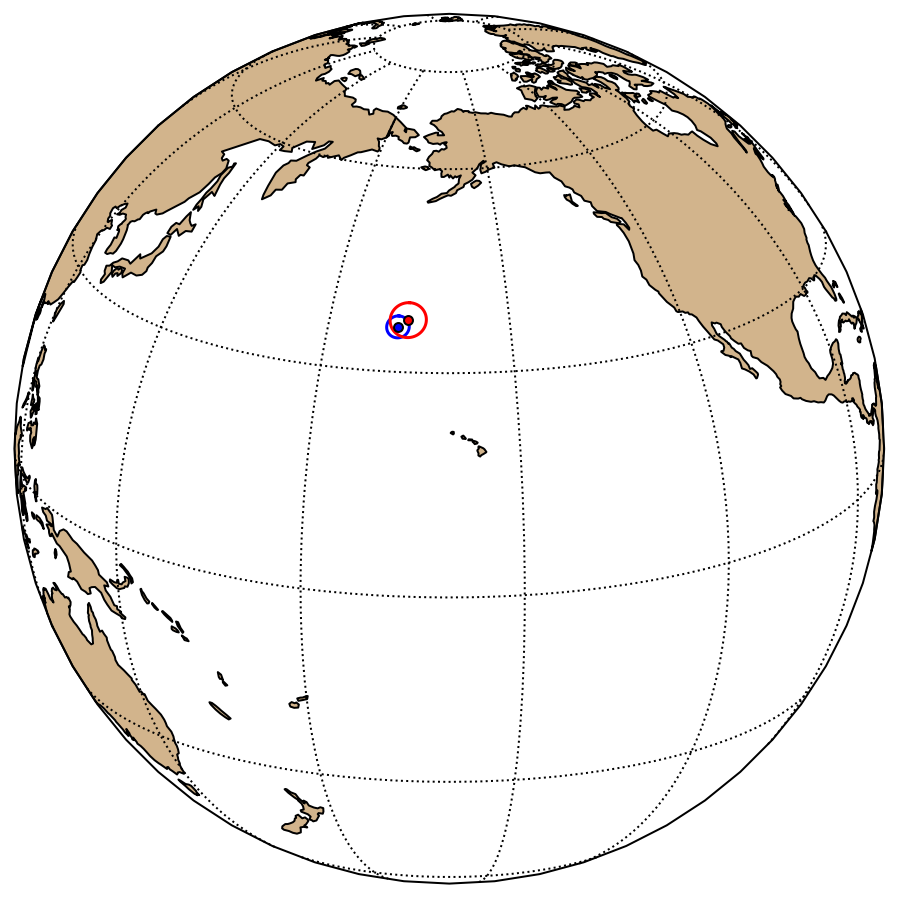

In [43]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD1['vgp_lon']), float(BD1['vgp_lat']), float(BD1['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX1['vgp_lon']), float(AX1['vgp_lat']), float(AX1['dir_alpha95']), color = 'r')

### Group 2: AX3-10, BD2

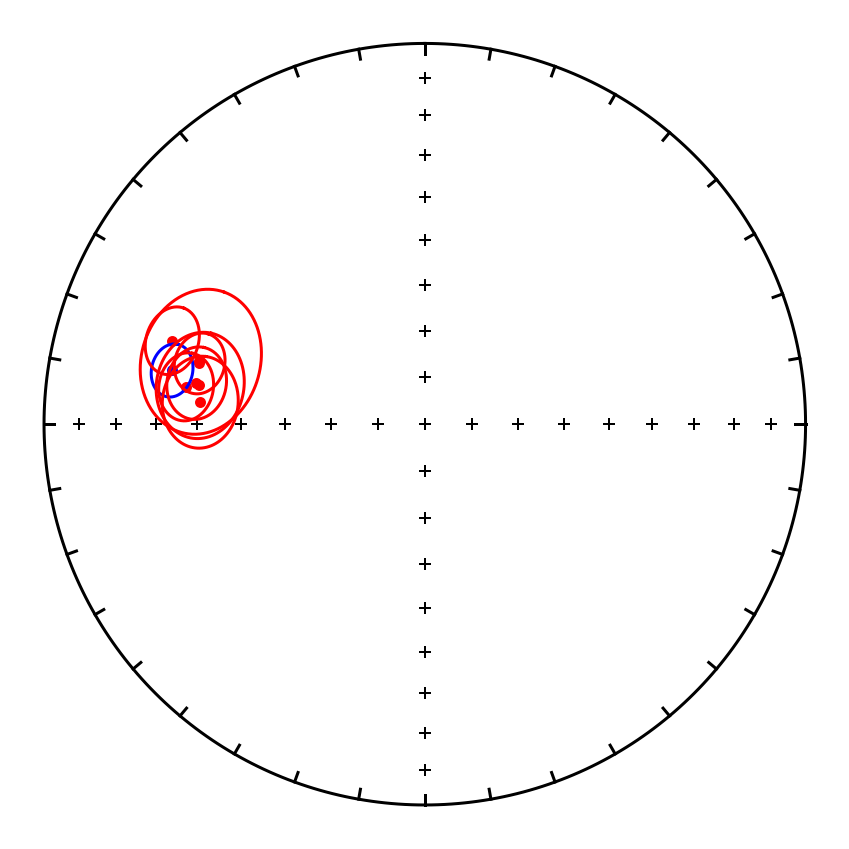

In [44]:
# AX3-10, BD2
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD2.dir_dec), float(BD2.dir_inc), float(BD2.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX3.dir_dec), float(AX3.dir_inc), float(AX3.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX4.dir_dec), float(AX4.dir_inc), float(AX4.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX5.dir_dec), float(AX5.dir_inc), float(AX5.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX6.dir_dec), float(AX6.dir_inc), float(AX6.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX7.dir_dec), float(AX7.dir_inc), float(AX7.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX8.dir_dec), float(AX8.dir_inc), float(AX8.dir_alpha95), color = 'red')
# ipmag.plot_di_mean(float(AX9.dir_dec), float(AX9.dir_inc), float(AX9.dir_alpha95), color = 'red') # has only two specimens, and one with bad orientation, thus has alpha 95 of 180
ipmag.plot_di_mean(float(AX10.dir_dec), float(AX10.dir_inc), float(AX10.dir_alpha95), color = 'red')
plt.show()

In [45]:
ipmag.common_mean_watson(BD2_blocks, AX3_blocks)

Results of Watson V test: 

Watson's V:           5.1
Critical value of V:  6.6
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.5
Critical angle for M&M1990:   7.4
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 6.481716675682815, 7.381845677821029)

In [46]:
ipmag.common_mean_watson(BD2_blocks, AX4_blocks)

Results of Watson V test: 

Watson's V:           3.7
Critical value of V:  6.9
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 5.7
Critical angle for M&M1990:   7.7
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 5.6630754249802, 7.709886389745996)

In [47]:
ipmag.common_mean_watson(BD2_blocks, AX5_blocks)

Results of Watson V test: 

Watson's V:           4.9
Critical value of V:  9.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.5
Critical angle for M&M1990:   8.8
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 6.506009870059915, 8.813454845188316)

In [48]:
ipmag.common_mean_watson(BD2_blocks, AX6_blocks)

Results of Watson V test: 

Watson's V:           6.1
Critical value of V:  7.7
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.5
Critical angle for M&M1990:   7.3
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 6.473958701165531, 7.285209526297485)

In [49]:
ipmag.common_mean_watson(BD2_blocks, AX7_blocks)

Results of Watson V test: 

Watson's V:           8.6
Critical value of V:  7.8
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 7.3
Critical angle for M&M1990:   6.9



(0, 7.2641579188759335, 6.949818022486795)

In [50]:
ipmag.common_mean_watson(BD2_blocks, AX8_blocks)

Results of Watson V test: 

Watson's V:           9.5
Critical value of V:  8.3
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 9.3
Critical angle for M&M1990:   8.7



(0, 9.28547986747856, 8.698118033833163)

In [51]:
ipmag.common_mean_watson(BD2_blocks, AX10_blocks)

Results of Watson V test: 

Watson's V:           3.5
Critical value of V:  7.3
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 4.8
Critical angle for M&M1990:   6.9
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 4.7834177168376675, 6.8659549322708315)

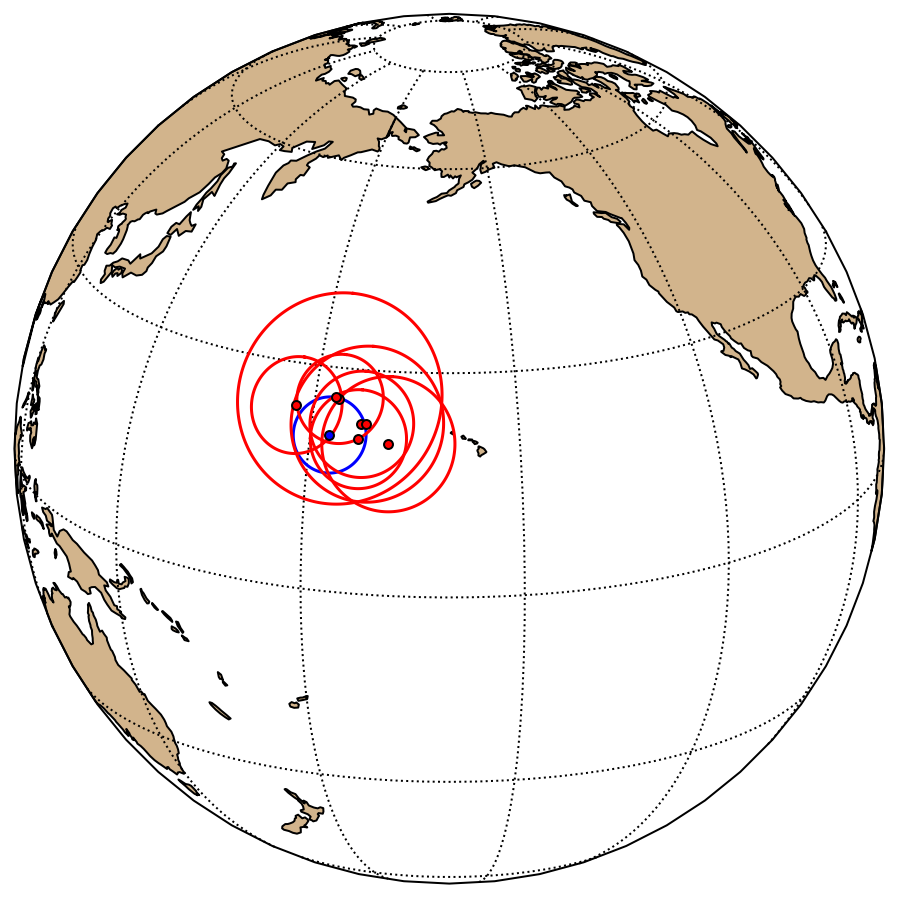

In [52]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD2['vgp_lon']), float(BD2['vgp_lat']), float(BD2['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX3['vgp_lon']), float(AX3['vgp_lat']), float(AX3['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX4['vgp_lon']), float(AX4['vgp_lat']), float(AX4['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX5['vgp_lon']), float(AX5['vgp_lat']), float(AX5['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX6['vgp_lon']), float(AX6['vgp_lat']), float(AX6['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX7['vgp_lon']), float(AX7['vgp_lat']), float(AX7['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX8['vgp_lon']), float(AX8['vgp_lat']), float(AX8['dir_alpha95']), color = 'r')
# ipmag.plot_pole(map_axis, float(AX9['vgp_lon']), float(AX9['vgp_lat']), float(AX9['dir_alpha95']), color = 'r')# has only two specimens, and one with bad orientation, thus has alpha 95 of 180
ipmag.plot_pole(map_axis, float(AX10['vgp_lon']), float(AX10['vgp_lat']), float(AX10['dir_alpha95']), color = 'r')
plt.show()

_Now lets try to treat site AX5-AX10 as one site_

In [53]:
AX5_AX10_mean = ipmag.fisher_mean(AX5_AX10['dir_dec'].tolist(), AX5_AX10['dir_inc'].tolist())
AX5_AX10_vgp_mean = ipmag.fisher_mean(AX5_AX10['vgp_lon'].tolist(), AX5_AX10['vgp_lat'].tolist())

ipmag.print_direction_mean(AX5_AX10_mean)
ipmag.print_pole_mean(AX5_AX10_vgp_mean)

Dec: 282.4  Inc: 37.1
Number of directions in mean (n): 6
Angular radius of 95% confidence (a_95): 5.7
Precision parameter (k) estimate: 139.1
Plon: 184.9  Plat: 23.3
Number of directions in mean (n): 6
Angular radius of 95% confidence (A_95): 5.5
Precision parameter (k) estimate: 147.7


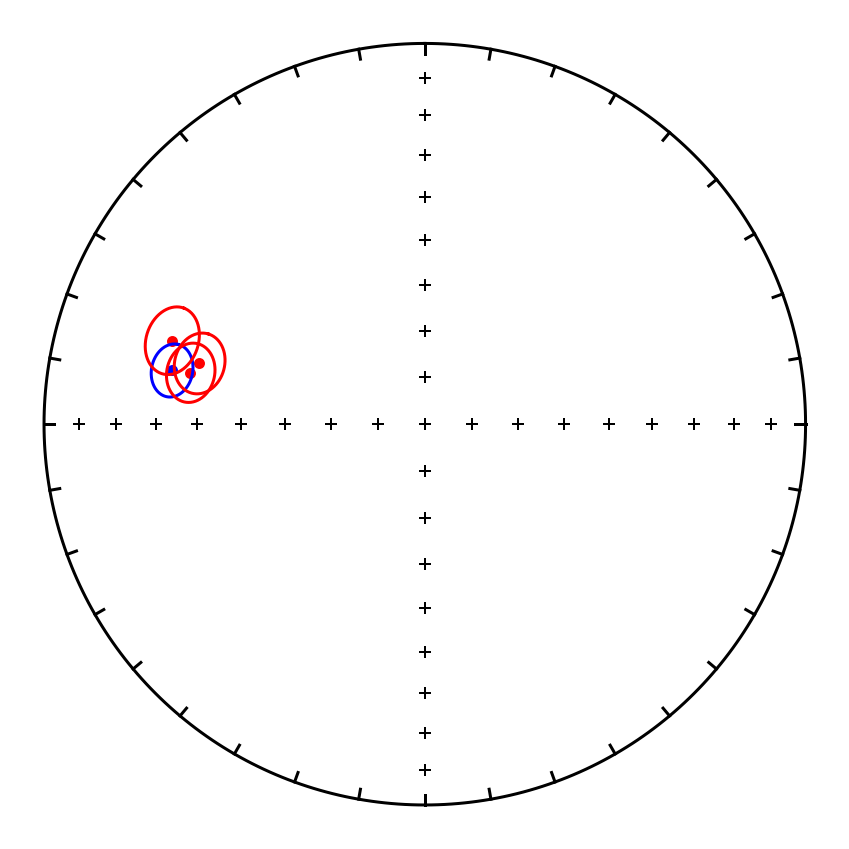

In [54]:
# AX3-10, BD2
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD2.dir_dec), float(BD2.dir_inc), float(BD2.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX5_AX10_mean['dec']), float(AX5_AX10_mean['inc']), float(AX5_AX10_mean['alpha95']), color = 'red')
ipmag.plot_di_mean(float(AX3.dir_dec), float(AX3.dir_inc), float(AX3.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX4.dir_dec), float(AX4.dir_inc), float(AX4.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair2.pdf')
plt.show()

In [55]:
ipmag.common_mean_watson(BD2_blocks, AX5_10_blocks)

Results of Watson V test: 

Watson's V:           6.5
Critical value of V:  6.6
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 5.6
Critical angle for M&M1990:   5.6
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 5.553311102686339, 5.628662961977577)

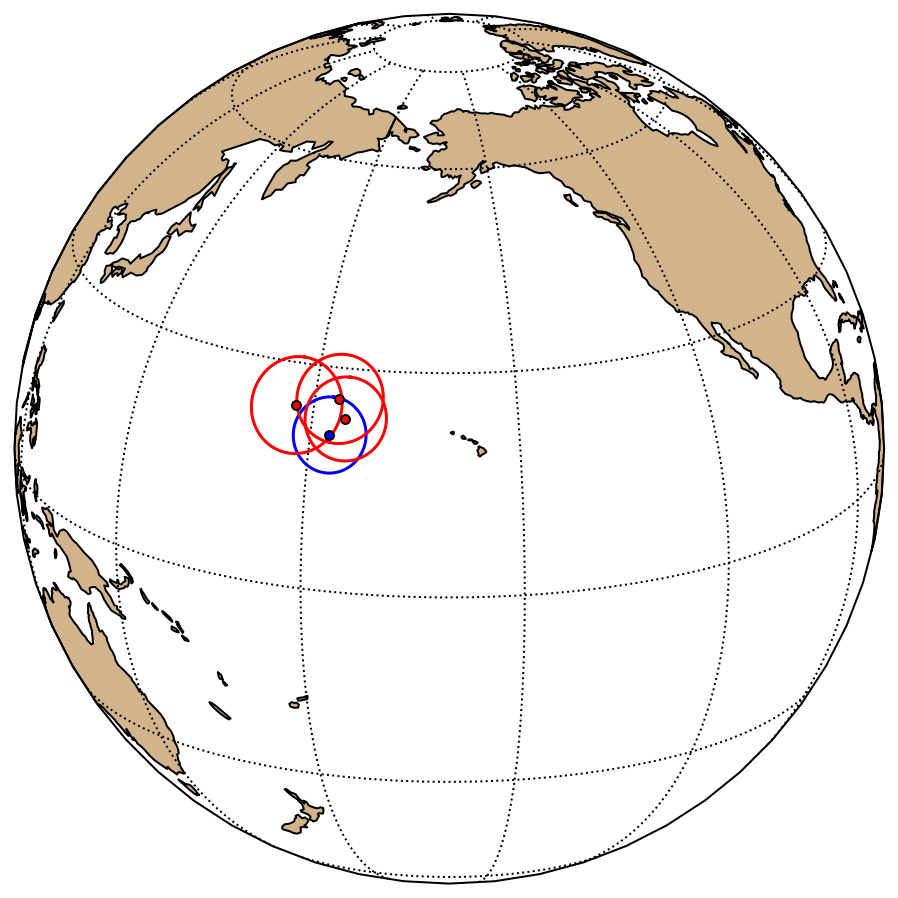

In [56]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD2['vgp_lon']), float(BD2['vgp_lat']), float(BD2['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX5_AX10_vgp_mean['dec']), float(AX5_AX10_vgp_mean['inc']), float(AX5_AX10_vgp_mean['alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX3['vgp_lon']), float(AX3['vgp_lat']), float(AX3['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX4['vgp_lon']), float(AX4['vgp_lat']), float(AX4['dir_alpha95']), color = 'r')
plt.show()

### Group 3: AX11, AX13, BD3

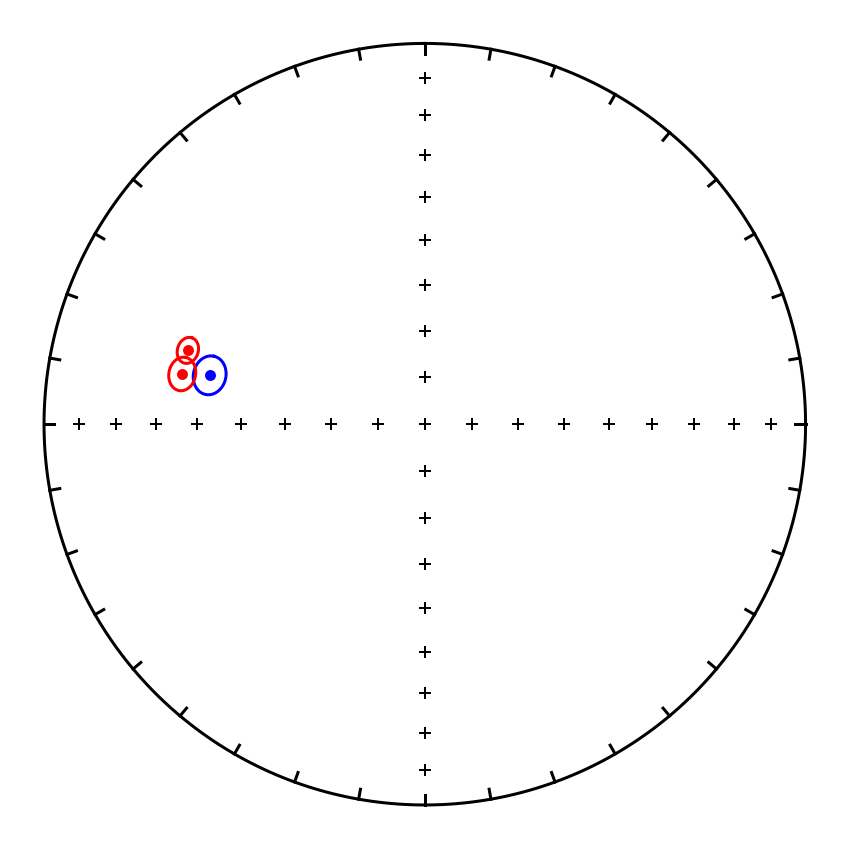

In [57]:
# AX11, AX13, BD3
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD3.dir_dec), float(BD3.dir_inc), float(BD3.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX11.dir_dec), float(AX11.dir_inc), float(AX11.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX13.dir_dec), float(AX13.dir_inc), float(AX13.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair3.pdf')
plt.show()

In [58]:
ipmag.common_mean_watson(BD3_blocks, AX11_blocks)

Results of Watson V test: 

Watson's V:           12.8
Critical value of V:  7.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 6.5
Critical angle for M&M1990:   4.8



(0, 6.472763867113259, 4.7855641636093695)

In [59]:
ipmag.common_mean_watson(BD3_blocks, AX13_blocks)

Results of Watson V test: 

Watson's V:           19.4
Critical value of V:  6.9
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 7.4
Critical angle for M&M1990:   4.4



(0, 7.355189351848276, 4.39869433021483)

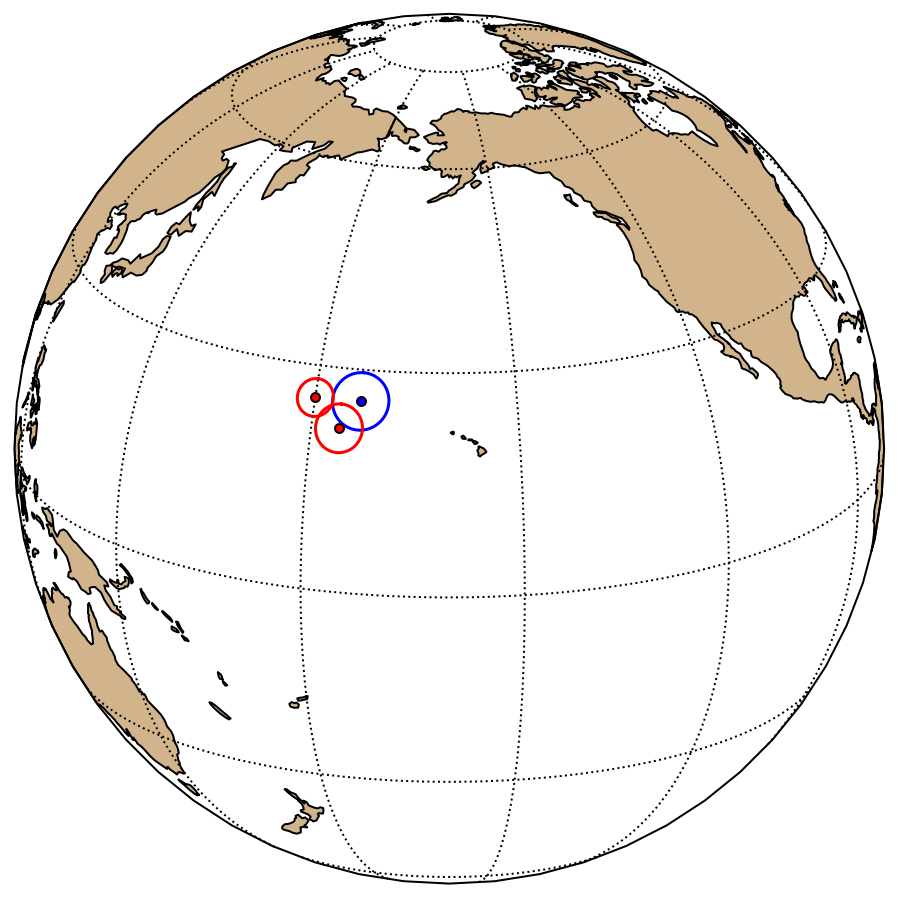

In [60]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD3['vgp_lon']), float(BD3['vgp_lat']), float(BD3['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX11['vgp_lon']), float(AX11['vgp_lat']), float(AX11['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX13['vgp_lon']), float(AX13['vgp_lat']), float(AX13['dir_alpha95']), color = 'r')

### Group 4: AX12, AX14, BD4

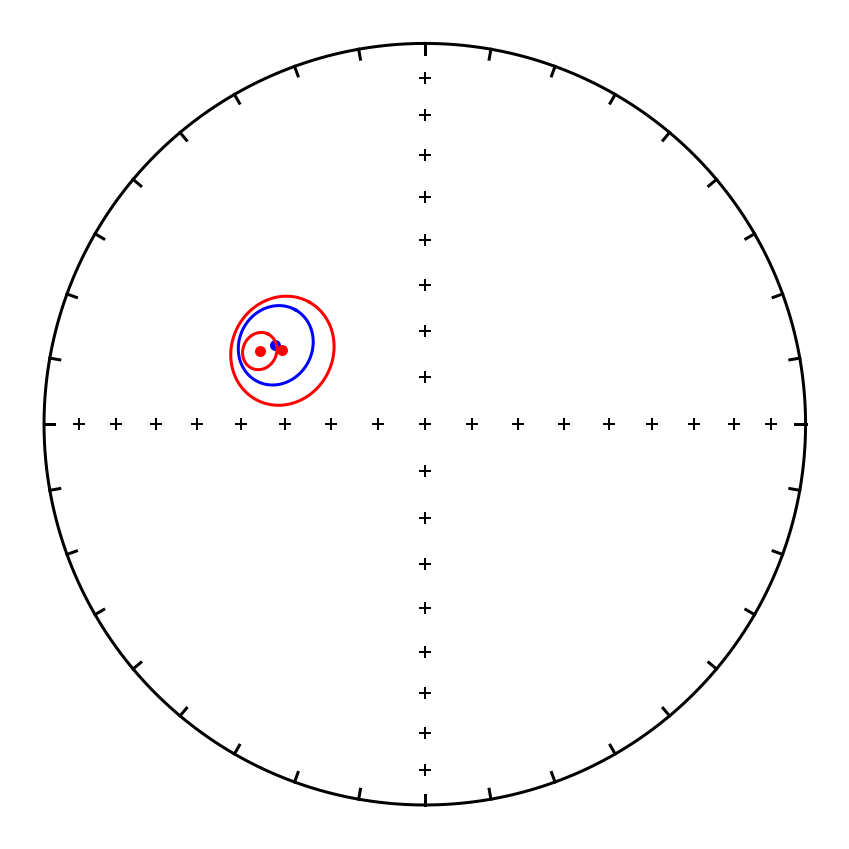

In [61]:
# AX12, AX14, BD4
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD4.dir_dec), float(BD4.dir_inc), float(BD4.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX12.dir_dec), float(AX12.dir_inc), float(AX12.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX14.dir_dec), float(AX14.dir_inc), float(AX14.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair4.pdf')
plt.show()

In [62]:
 ipmag.common_mean_watson(BD4_blocks, AX12_blocks)

Results of Watson V test: 

Watson's V:           0.1
Critical value of V:  7.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.9
Critical angle for M&M1990:   13.2
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 1.8658907639587745, 13.211376305673765)

In [63]:
 ipmag.common_mean_watson(BD4_blocks, AX14_blocks)

Results of Watson V test: 

Watson's V:           1.2
Critical value of V:  7.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 3.5
Critical angle for M&M1990:   8.7
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 3.528479246309162, 8.718625729671428)

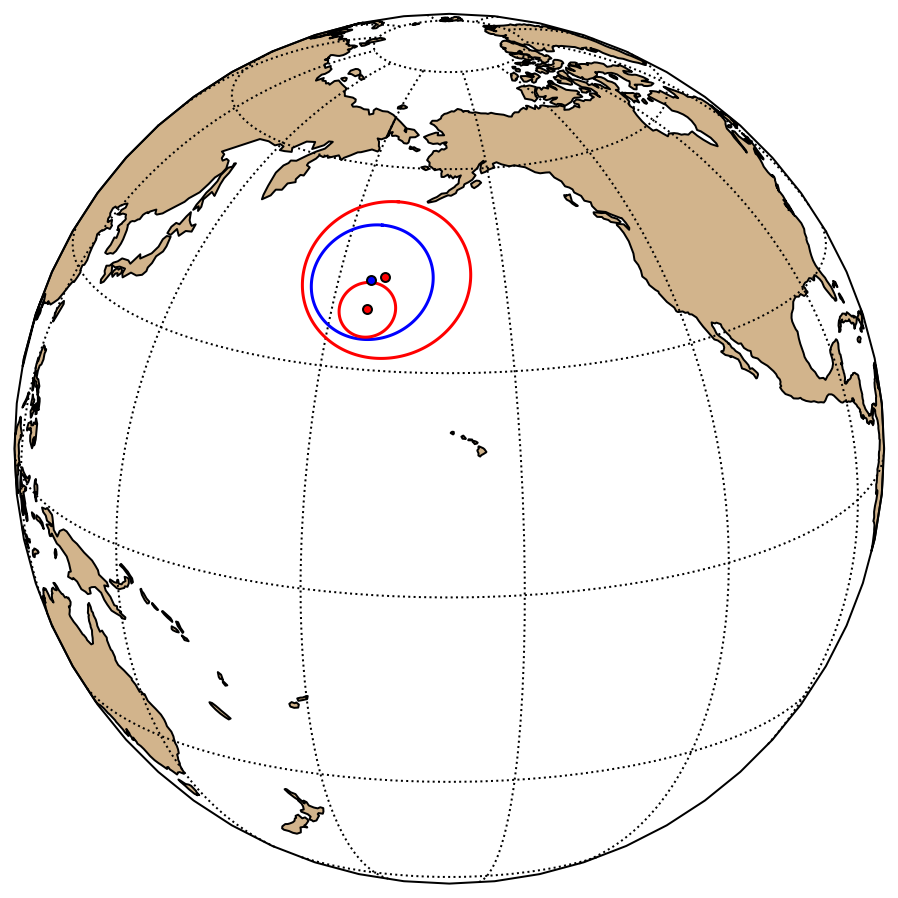

In [64]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD4['vgp_lon']), float(BD4['vgp_lat']), float(BD4['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX12['vgp_lon']), float(AX12['vgp_lat']), float(AX12['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX14['vgp_lon']), float(AX14['vgp_lat']), float(AX14['dir_alpha95']), color = 'r')

### Group 5: AX15-18, BD5

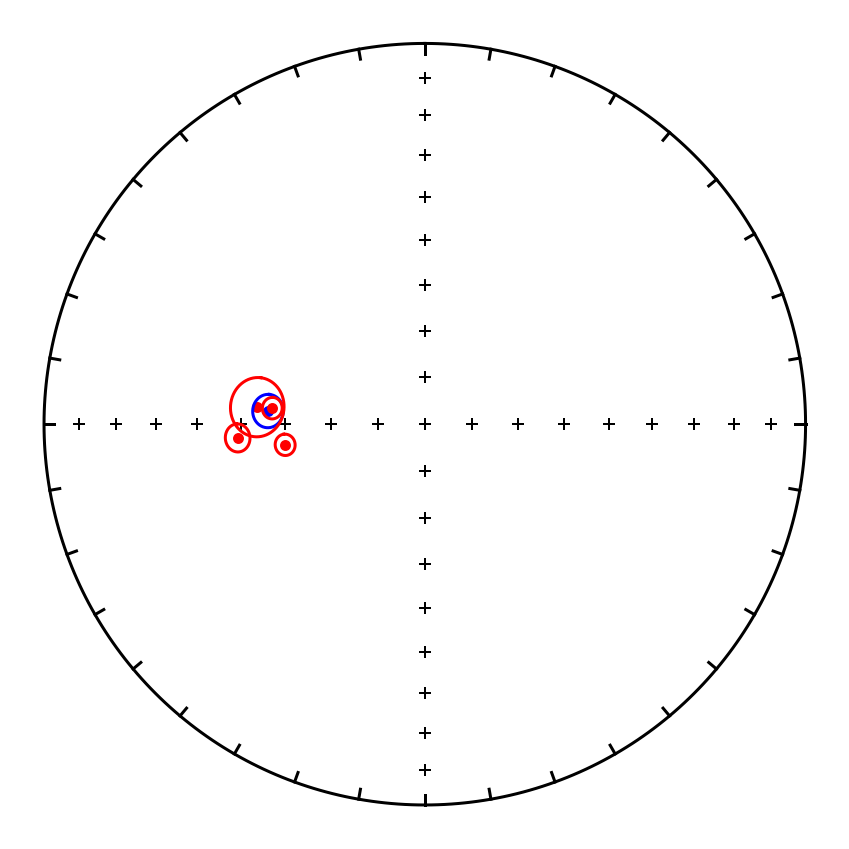

In [65]:
# AX15-18, BD5
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD5.dir_dec), float(BD5.dir_inc), float(BD5.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX15.dir_dec), float(AX15.dir_inc), float(AX15.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX16.dir_dec), float(AX16.dir_inc), float(AX16.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX17.dir_dec), float(AX17.dir_inc), float(AX17.dir_alpha95), color = 'red')
ipmag.plot_di_mean(float(AX18.dir_dec), float(AX18.dir_inc), float(AX18.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair5.pdf')
plt.show()

In [66]:
 ipmag.common_mean_watson(BD5_blocks, AX15_blocks)

Results of Watson V test: 

Watson's V:           1.0
Critical value of V:  6.8
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 2.5
Critical angle for M&M1990:   6.5
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 2.5379595663602927, 6.543077172287133)

In [67]:
 ipmag.common_mean_watson(BD5_blocks, AX16_blocks)

Results of Watson V test: 

Watson's V:           29.9
Critical value of V:  6.6
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 8.7
Critical angle for M&M1990:   4.1



(0, 8.742344688242946, 4.106129911444272)

In [68]:
 ipmag.common_mean_watson(BD5_blocks, AX17_blocks)

Results of Watson V test: 

Watson's V:           29.0
Critical value of V:  6.9
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 7.9
Critical angle for M&M1990:   3.9



(0, 7.914583470997726, 3.8503948311416707)

In [69]:
 ipmag.common_mean_watson(BD5_blocks, AX18_blocks)

Results of Watson V test: 

Watson's V:           0.5
Critical value of V:  6.7
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.1
Critical angle for M&M1990:   3.8
The McFadden and McElhinny (1990) classification for
this test is: 'A'


(1, 1.0887858453123966, 3.840238824063879)

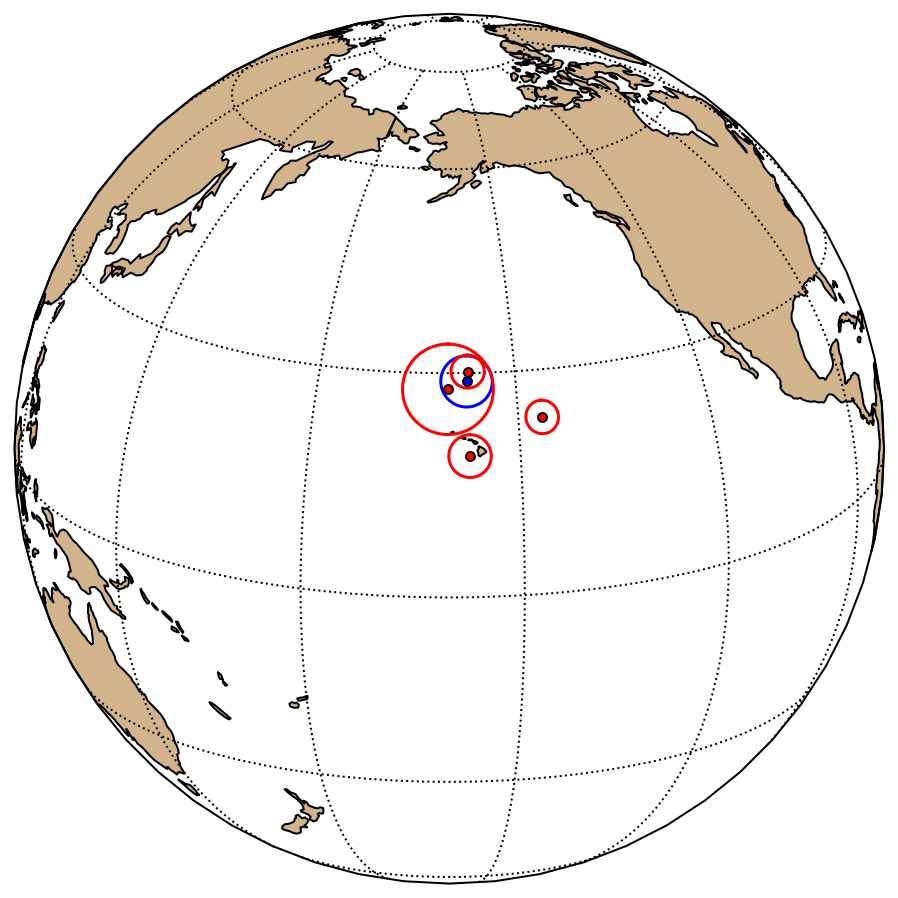

In [70]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD5['vgp_lon']), float(BD5['vgp_lat']), float(BD5['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX15['vgp_lon']), float(AX15['vgp_lat']), float(AX15['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX16['vgp_lon']), float(AX16['vgp_lat']), float(AX16['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX17['vgp_lon']), float(AX17['vgp_lat']), float(AX17['dir_alpha95']), color = 'r')
ipmag.plot_pole(map_axis, float(AX18['vgp_lon']), float(AX18['vgp_lat']), float(AX18['dir_alpha95']), color = 'r')

### Group 6: AX19, BD6

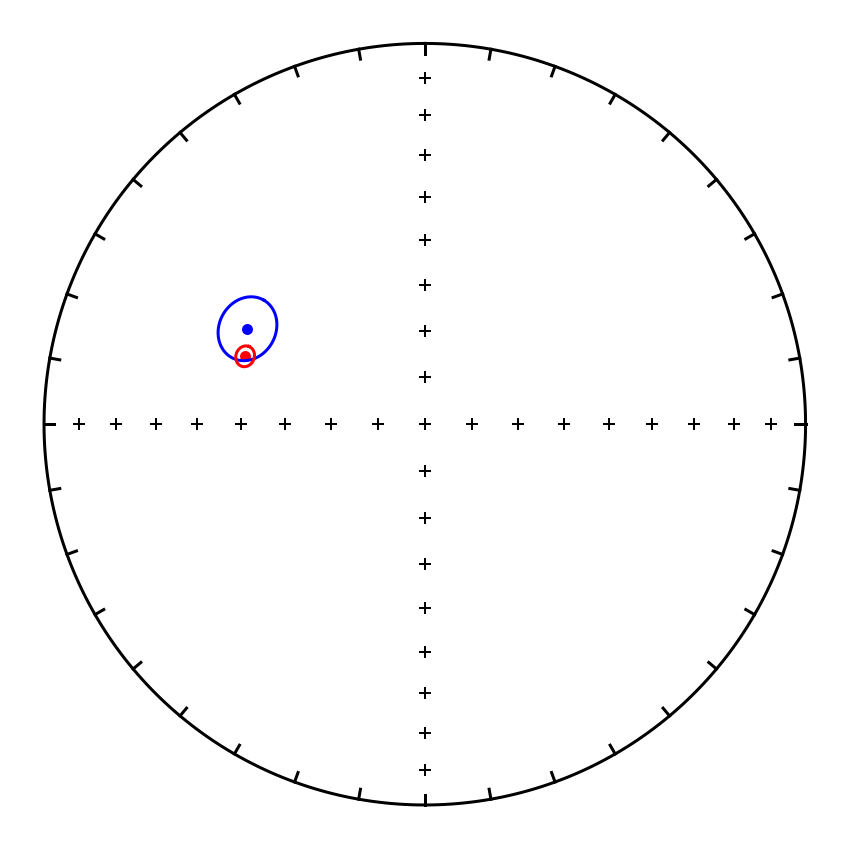

In [71]:
# AX19, BD6
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD6.dir_dec), float(BD6.dir_inc), float(BD6.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX19.dir_dec), float(AX19.dir_inc), float(AX19.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair6.pdf')
plt.show()

In [72]:
 ipmag.common_mean_watson(BD6_blocks, AX19_blocks)

Results of Watson V test: 

Watson's V:           5.0
Critical value of V:  7.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 5.6
Critical angle for M&M1990:   6.7
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 5.6329629142040405, 6.734588408447525)

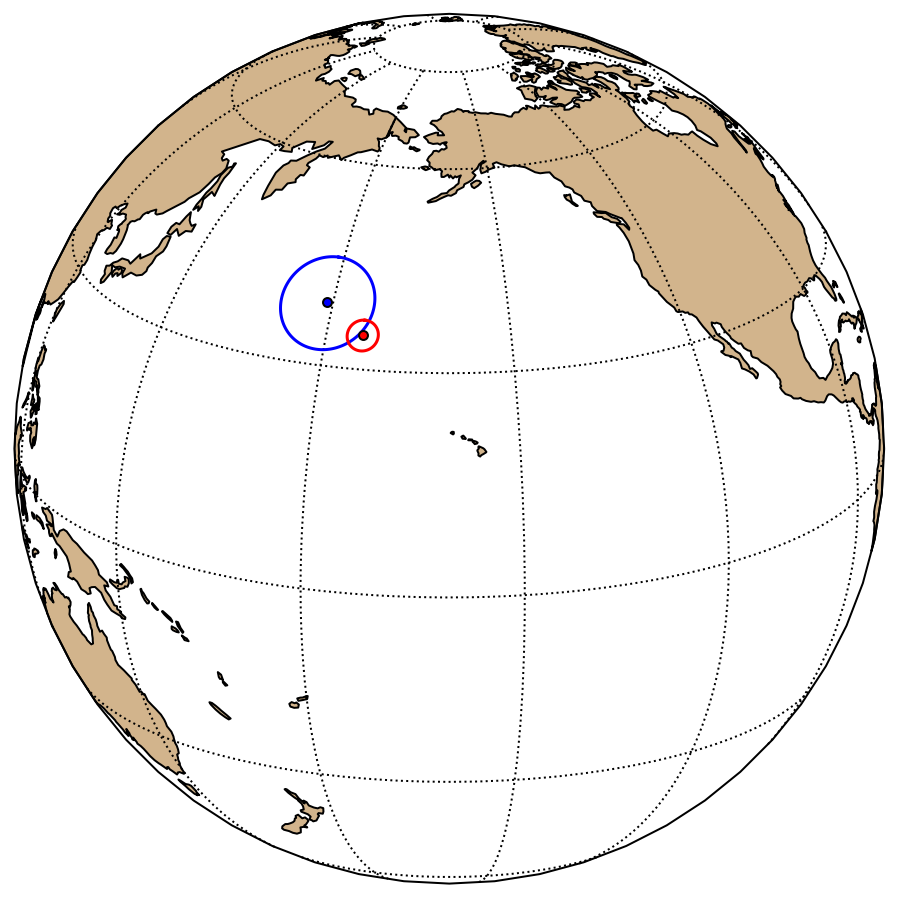

In [73]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD6['vgp_lon']), float(BD6['vgp_lat']), float(BD6['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX19['vgp_lon']), float(AX19['vgp_lat']), float(AX19['dir_alpha95']), color = 'r')

### Group 7: AX20, BD7

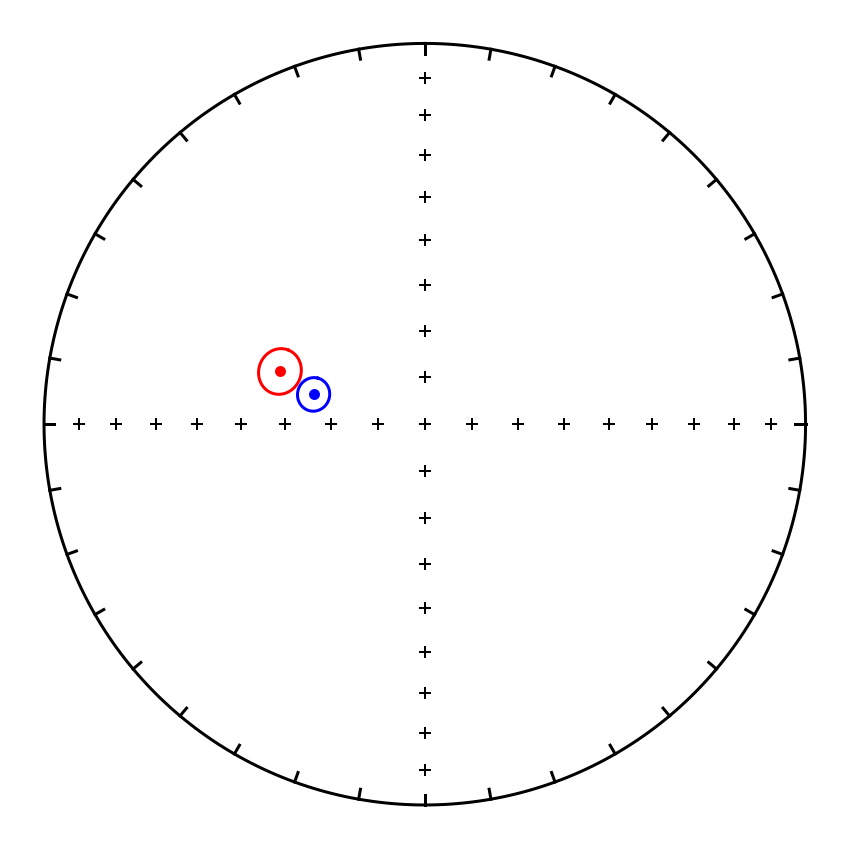

In [74]:
# AX20, AX21, BD7
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD7.dir_dec), float(BD7.dir_inc), float(BD7.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX20.dir_dec), float(AX20.dir_inc), float(AX20.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair7.pdf')
plt.show()

In [75]:
 ipmag.common_mean_watson(BD7_blocks, AX20_blocks)

Results of Watson V test: 

Watson's V:           19.9
Critical value of V:  7.2
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 8.9
Critical angle for M&M1990:   5.4



(0, 8.89501396757701, 5.363999371273619)

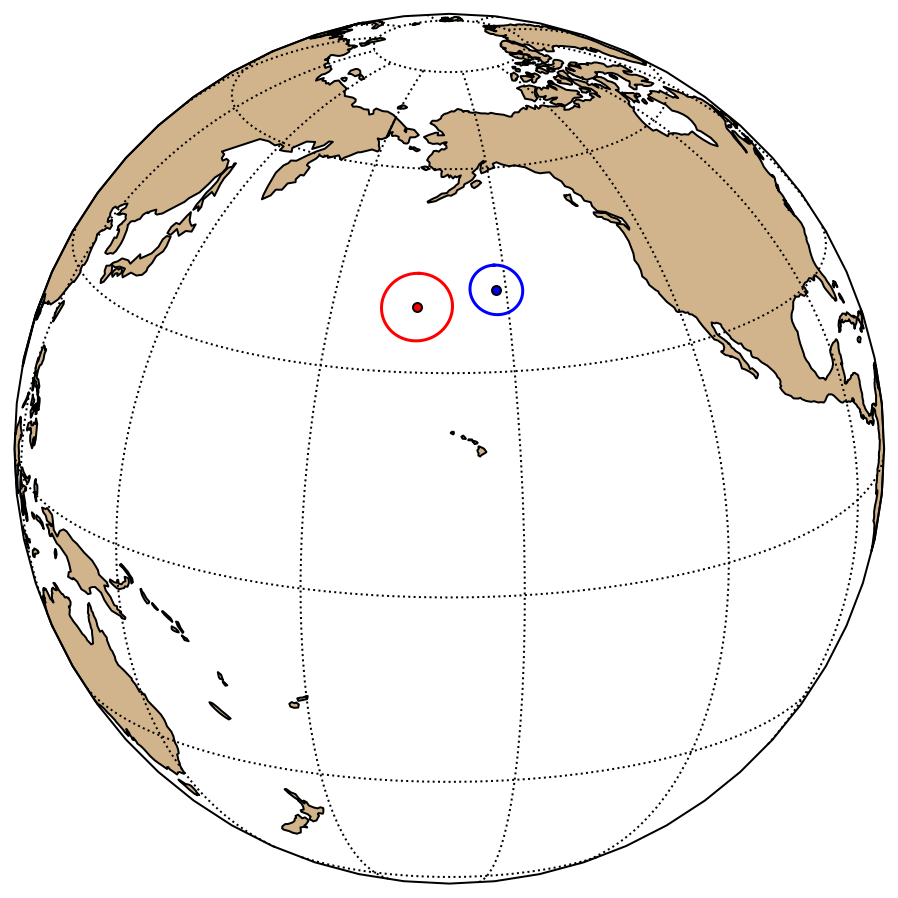

In [76]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD7['vgp_lon']), float(BD7['vgp_lat']), float(BD7['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX20['vgp_lon']), float(AX20['vgp_lat']), float(AX20['dir_alpha95']), color = 'r')

### Group 8: AX22, BD10

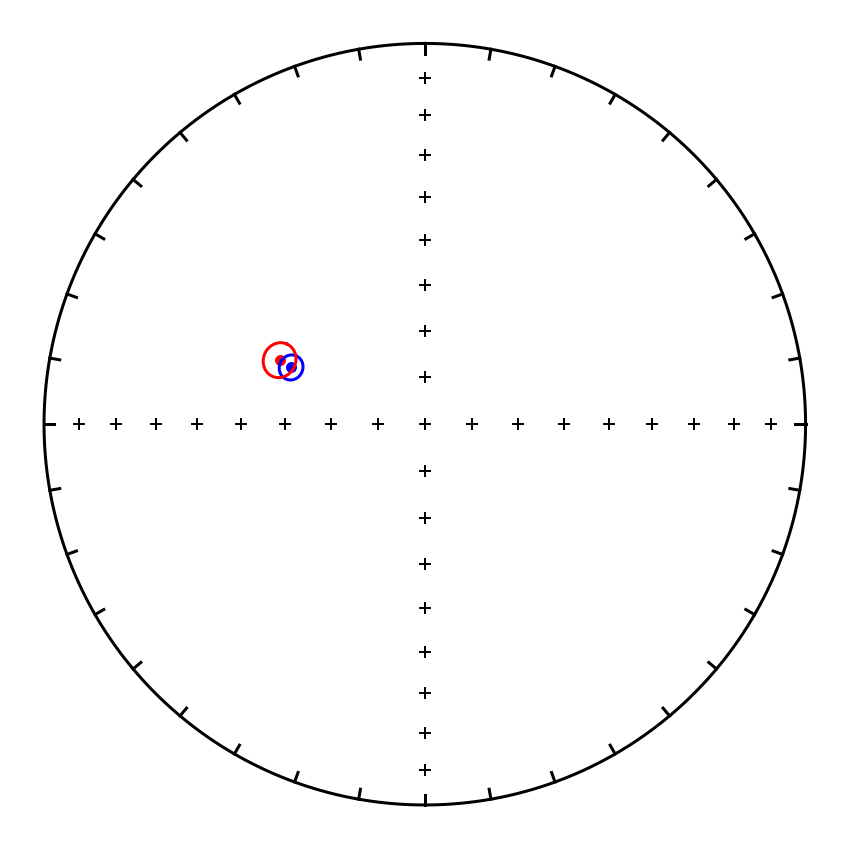

In [77]:
# AX22, BD10
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(float(BD10.dir_dec), float(BD10.dir_inc), float(BD10.dir_alpha95), color = 'blue')
ipmag.plot_di_mean(float(AX22.dir_dec), float(AX22.dir_inc), float(AX22.dir_alpha95), color = 'red')
# plt.savefig('code_output/pmag/pair8.pdf')
plt.show()

In [78]:
ipmag.common_mean_watson(BD10_blocks, AX22_blocks)

Results of Watson V test: 

Watson's V:           3.4
Critical value of V:  6.8
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 3.0
Critical angle for M&M1990:   4.3
The McFadden and McElhinny (1990) classification for
this test is: 'A'


(1, 3.0372355314265853, 4.310325351549559)

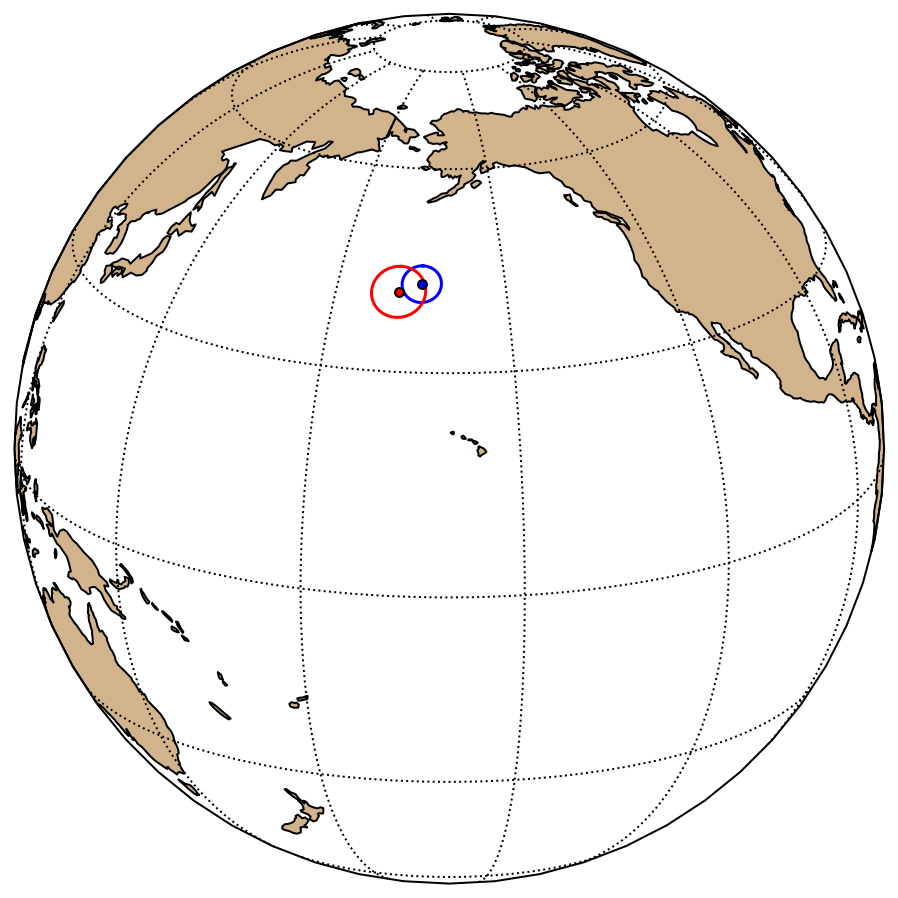

In [79]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_pole(map_axis, float(BD10['vgp_lon']), float(BD10['vgp_lat']), float(BD10['dir_alpha95']), color = 'blue')
ipmag.plot_pole(map_axis, float(AX22['vgp_lon']), float(AX22['vgp_lat']), float(AX22['dir_alpha95']), color = 'r')

### all site common mean test

In [80]:
# site common mean test
All_AX_blocks = ipmag.make_di_block(AX_site_mct_tc['dir_dec'].tolist(), AX_site_mct_tc['dir_inc'].tolist())
All_BD_blocks = ipmag.make_di_block(BD_site_mct_tc['dir_dec'].tolist(), BD_site_mct_tc['dir_inc'].tolist())

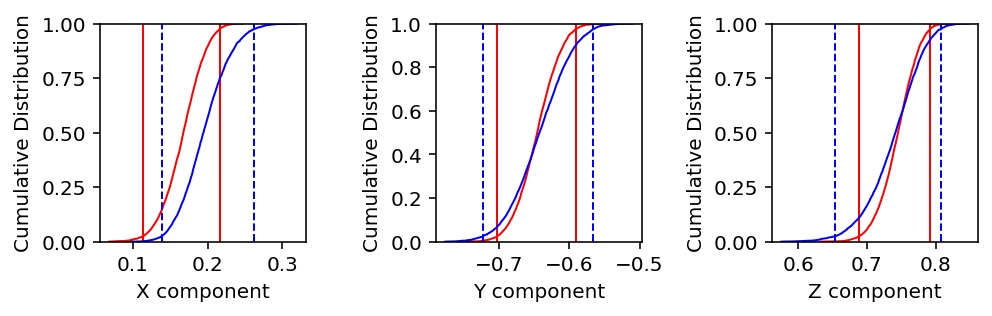

In [81]:
ipmag.common_mean_bootstrap(All_AX_blocks, All_BD_blocks)

In [82]:
ipmag.common_mean_watson(All_AX_blocks, All_BD_blocks)

Results of Watson V test: 

Watson's V:           0.3
Critical value of V:  6.6
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.7
Critical angle for M&M1990:   8.6
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 1.6843110371754602, 8.576852495548264)

## Combine diabase and anorthosite sites into cooling unit means and construct a mean pole for Beaver River diabase emplacement pole position

<center>
    
| Cooling unit #| AX sites| BD sites | Note |
| :------------- | :----------: | -----------: | -----------: |
| 1 | AX1 | BD1 | This xenolith site is hosted by BD1 diabase site and their directions agree very well|
| 2 | AX3, AX4, AX5, AX6, AX7, AX8, AX9, AX10 | BD2 | All of these xenoliths are hosted by the same Carlton Peak BD2 sill |
| 3 | AX11, AX13 | BD3 | These two anorthosite xenoliths are hosted by the same Kennedy Creek BD3 diabase sill | 
| 4 | AX12, AX14 | BD4 | These two anorthosite xenoliths are in close proximity hosted by BD4 diabase sill |
| 5 | AX15, AX16, AX17, AX18 | BD5 | These anorthosite xenoliths are in close proximity hosted by a Silver Bay BD5 diabase sill |
| 6 | AX19 | BD6 | This xenolith site is hosted by BD6 diabase site and their directions agree very well |
| 7 | AX20 | BD7 | This xenolith site is hosted by BD7 diabase site and their directions agree very well |
| 8 | AX22 | BD10| This xenolith site is hosted by BD10 diabase site and their directions agree very well |
| 9 | AX21 | | This xenolith site is about 300 meters from BD7 diabase, and have a shallower direction than AX20 and BD7 |
| 10 | | BD8 | single diabase site |
| 11 | | BD9 | single diabase site |
| 12 | | BD11 | single diabase site |
| 13 | | BD12 | single diabase site |
| 14 | | BD13 | single diabase site |
| 15 | | BD15 | single diabase site |
| 16 | | BD17 | single diabase site |  
|  | AX2 | | This xenolith is hosted by BD1 but it has an overprint with later secondary oxidation event |
|  | | BD14 | Large overprint, not taken into calculation |
|  | | BD16 | Large overprint, not taken into calculation |
</center>

In [83]:
# pull specimen files in to cooling units (CU)
# all directions are tilt corrected already

CU1 = pd.concat([AX1_specs, BD1_specs])
CU2 = pd.concat([AX3_specs, 
                 AX4_specs, 
                 AX5_specs, 
                 AX6_specs, 
                 AX7_specs, 
                 AX8_specs, 
                 AX9_specs, 
                 AX10_specs, BD2_specs])
CU3 = pd.concat([AX11_specs, AX13_specs, BD3_specs])
CU4 = pd.concat([AX12_specs, AX14_specs, BD4_specs])
CU5 = pd.concat([AX15_specs, 
                 AX16_specs, 
                 AX17_specs, 
                 AX18_specs, BD5_specs])
CU6 = pd.concat([AX19_specs, BD6_specs])
CU7 = pd.concat([AX20_specs, BD7_specs])
CU8 = pd.concat([AX22_specs, BD10_specs])
CU9 = AX21_specs
CU10 = BD8_specs
CU11 = BD9_specs
CU12 = BD11_specs
CU13 = BD12_specs
CU14 = BD13_specs
CU15 = BD15_specs
CU16 = BD17_specs

In [84]:
columns = ['Cooling Unit', 'dec_tc', 'inc_tc', 'alpha95', 'n', 'k']
CU_lons = [-91.379371, -90.856288, -91.167418, -91.26039, -91.26365,
           -91.292925, -91.288383, -91.159176, -91.291029, -91.356198, 
           -91.347111, -91.27416, -91.328796, -91.123713, -90.639617, -91.164446]
CU_lats = [47.200436, 47.582703, 47.368922, 47.291835, 47.288661, 
           47.263413, 47.26661, 47.411406, 47.268486, 47.212553, 
           47.224252, 47.368044, 47.304809, 47.480383, 47.700439, 47.373971]

CU_compilation = pd.DataFrame(columns=columns)
cooling_units = [CU1, CU2, CU3, CU4, CU5, CU6, CU7, CU8, CU9, CU10, CU11, CU12, CU13, CU14, CU15, CU16]

for i in range(len(cooling_units)):
    this_mean = ipmag.fisher_mean(cooling_units[i]['dir_dec'].tolist(), cooling_units[i]['dir_inc'].tolist())
#     print(i, this_mean)
    CU_compilation = CU_compilation.append(pd.DataFrame([['CU'+str(i+1), 
                                            this_mean['dec'], this_mean['inc'], 
                                            this_mean['alpha95'], 
                                            this_mean['n'], this_mean['k']]], columns=columns), ignore_index=True)

CU_compilation['lon'] = CU_lons
CU_compilation['lat'] = CU_lats

CU_compilation = ipmag.vgp_calc(CU_compilation, tilt_correction='yes',  
                                    site_lon='lon',
                                    site_lat='lat',
                                    dec_is='dec_tc',
                                    inc_is='inc_tc',)
CU_compilation

Cooling Unit      dec_tc     inc_tc   alpha95   n           k        lon  \
0           CU1  288.856164  53.765464  1.207352  24  601.447898 -91.379371   
1           CU2  283.485793  35.785156  2.434637  39   89.514851 -90.856288   
2           CU3  284.100197  37.248595  2.077850  25  195.068246 -91.167418   
3           CU4  296.330123  53.055448  4.082968  21   61.587260 -91.260390   
4           CU5  270.983251  55.225147  1.925420  41  135.359994 -91.263650   
5           CU6  294.739092  47.094450  3.531703  17  102.985727 -91.292925   
6           CU7  287.412036  61.735181  3.459236  12  158.404683 -91.288383   
7           CU8  293.386651  57.294229  2.118690  19  251.893387 -91.159176   
8           CU9  299.940518  50.540577  1.981368   8  782.577086 -91.291029   
9          CU10  278.778760  64.495594  2.784998  10  301.851493 -91.356198   
10         CU11  272.310904  44.606707  8.209640   7   55.019307 -91.347111   
11         CU12  292.953980  54.186996  2.691125   8  424.654834 -91.274160   
12         CU13  284.055264  50.055080  4.691021   8  140.394890 -91.328796   
13         CU14  276.930498  33.618325  2.998589   8  342.219989 -91.123713   
14         CU15  299.055834  12.745157  5.217955   9   98.316981 -90.639617   
15         CU16  292.859138  40.950281  2.360024   8  551.881345 -91.164446   

          lat  paleolatitude    vgp_lat     vgp_lon  vgp_lat_rev  vgp_lon_rev  
0   47.200436      34.305720  36.507587  192.077470   -36.507587    12.077470  
1   47.582703      19.819897  23.471892  183.316437   -23.471892     3.316437  
2   47.368922      20.816277  24.562438  183.445590   -24.562438     3.445590  
3   47.291835      33.618349  41.098836  186.681162   -41.098836     6.681162  
4   47.288661      35.756902  26.028155  204.185894   -26.028155    24.185894  
5   47.263413      28.278455  36.731761  182.342484   -36.731761     2.342484  
6   47.266610      42.921851  40.459190  202.028480   -40.459190    22.028480  
7   47.411406      37.906376  41.625883  193.184698   -41.625883    13.184698  
8   47.268486      31.275519  42.128549  181.719023   -42.128549     1.719023  
9   47.212553      46.344382  37.051274  209.903101   -37.051274    29.903101  
10  47.224252      26.251706  20.440023  195.645351   -20.440023    15.645351  
11  47.368044      34.719465  39.504756  189.929698   -39.504756     9.929698  
12  47.304809      30.838953  31.209130  191.805863   -31.209130    11.805863  
13  47.480383      18.388342  18.052741  186.662252   -18.052741     6.662252  
14  47.700439       6.452394  24.073096  161.415393   -24.073096   341.415393  
15  47.373971      23.455164  32.289926  179.332953   -32.289926   359.332953

In [85]:
# overall direction mean 
CU_direction_mean = ipmag.fisher_mean(CU_compilation['dec_tc'].tolist(), CU_compilation['inc_tc'].tolist())
CU_direction_mean

{'dec': 287.4775925088637,
 'inc': 47.48048087240646,
 'n': 16,
 'r': 15.543209637619777,
 'k': 32.83782066206181,
 'alpha95': 6.534488615365387,
 'csd': 14.135066483929593}

In [86]:
# overall pole mean 
CU_pole_mean = ipmag.fisher_mean(CU_compilation['vgp_lon'].tolist(), CU_compilation['vgp_lat'].tolist())
CU_pole_mean

{'dec': 188.7926452173535,
 'inc': 32.70152496206031,
 'n': 16,
 'r': 15.631619464122227,
 'k': 40.718763721482155,
 'alpha95': 5.850906585453416,
 'csd': 12.693685295962624}

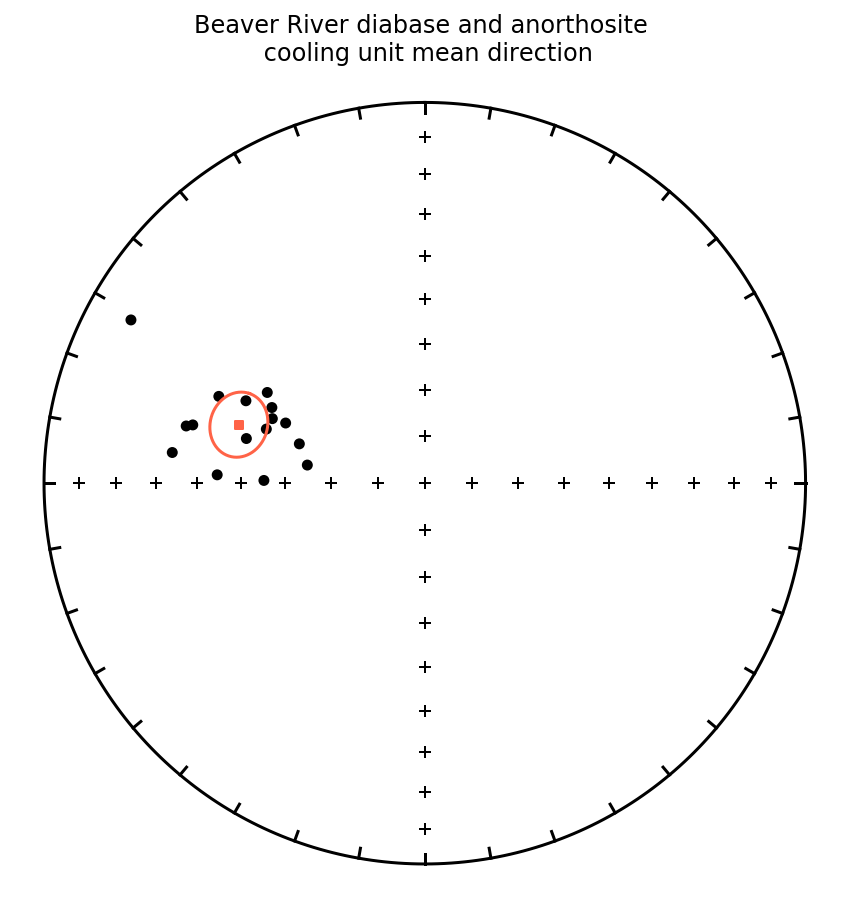

In [87]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(dec=CU_compilation['dec_tc'].tolist(), inc=CU_compilation['inc_tc'].tolist(), color = 'k')

ipmag.plot_di_mean(CU_direction_mean['dec'], CU_direction_mean['inc'], CU_direction_mean['alpha95'], marker = 's', color = 'tomato')
plt.title('Beaver River diabase and anorthosite \n cooling unit mean direction')
# plt.savefig('code_output/pmag/cooling_unit_mean.pdf', bbox_inches='tight')
plt.show()

### Test if VGP distribution is Fisherian

{'Mode': 'Mode 1',
 'Dec': 188.87468784708435,
 'Inc': 32.755816526564914,
 'N': 16,
 'Mu': -0.46072459392325626,
 'Mu_critical': 1.207,
 'Me': 0.7292427889869239,
 'Me_critical': 1.094,
 'Test_result': 'consistent with Fisherian model'}

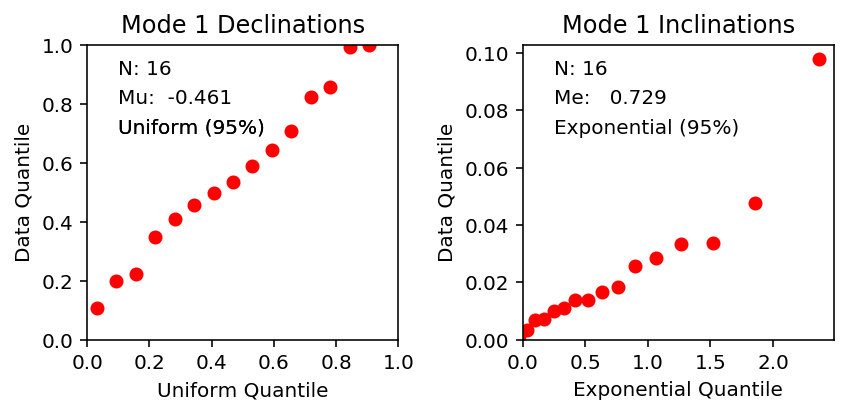

In [88]:
ipmag.fishqq(CU_compilation['vgp_lon'].tolist(), CU_compilation['vgp_lat'].tolist())

### Cooling mean pole compared to PLV mean pole
The mean pole position from the PLV is from:
Swanson-Hysell, N. L., Ramezani, J., Fairchild, L. M., & Rose, I. R. (2019). Failed rifting and fast drifting: Midcontinent rift development, Laurentia’s rapid motion and the driver of Grenvillian orogenesis. Bulletin, 131(5-6), 913-940.

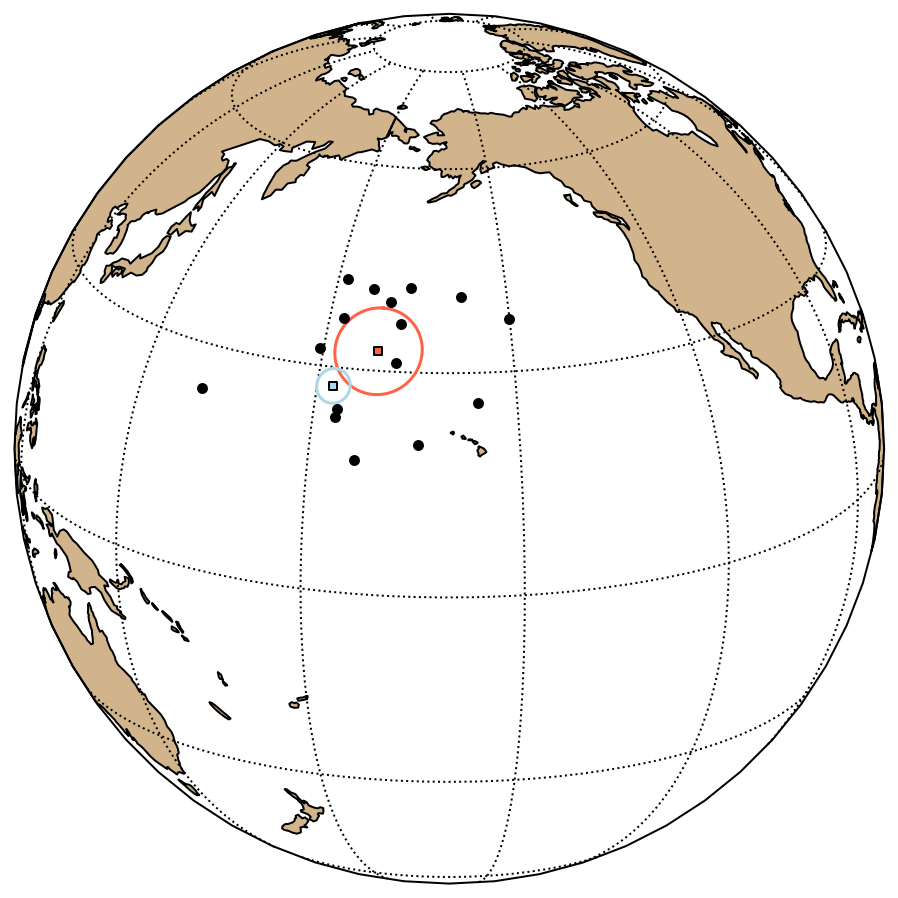

In [89]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)
ipmag.plot_vgp(map_axis, CU_compilation['vgp_lon'].tolist(), CU_compilation['vgp_lat'].tolist(), color = 'k')
    
ipmag.plot_pole(map_axis, CU_pole_mean['dec'], CU_pole_mean['inc'], CU_pole_mean['alpha95'],
                marker = 's', color = 'tomato', label = 'cooling unit mean pole')
ipmag.plot_pole(map_axis, 182.5, 27.5, 2.3, marker = 's', color = 'lightblue', label = 'PLV pole')
plt.show()

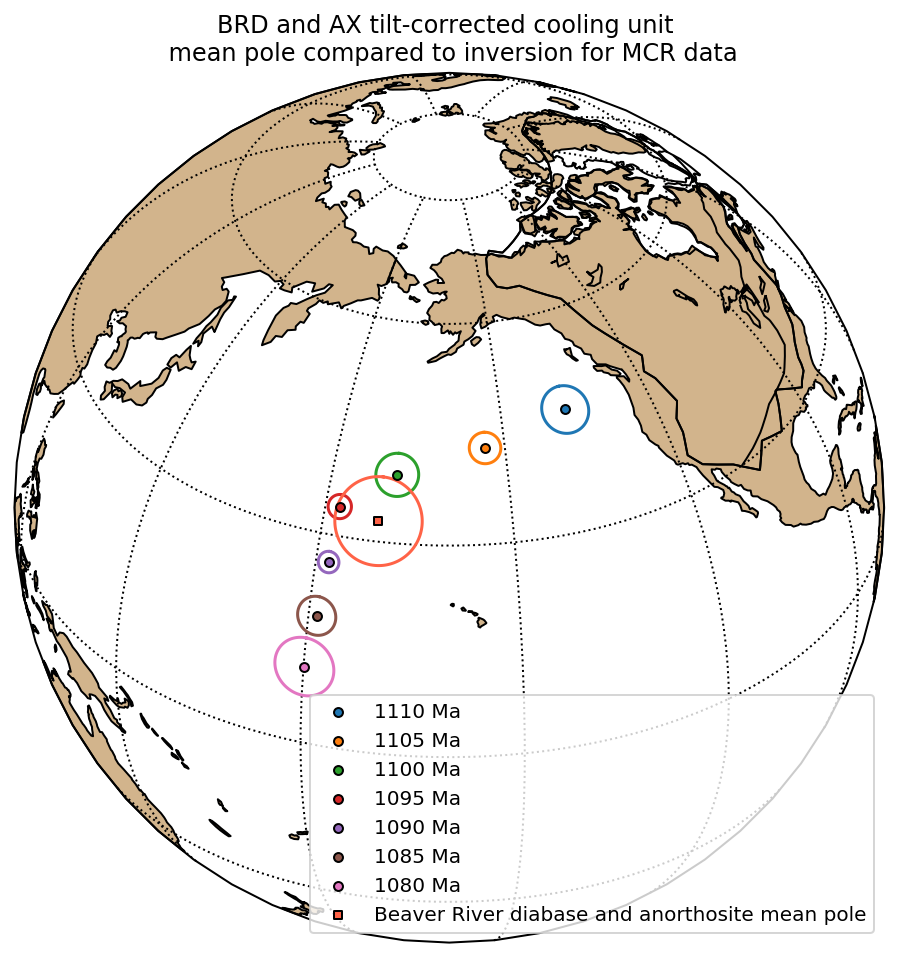

In [90]:
one_Euler_pole_lon = np.loadtxt('../Data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../Data/mcplates_results/pole_lat_positions_2_true.txt')

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color='C0',label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color='C1',label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color='C2',label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color='C3',label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color='C4',label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color='C5',label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color='C6',label='1080 Ma')

ipmag.plot_pole(m, CU_pole_mean['dec'], CU_pole_mean['inc'], CU_pole_mean['alpha95'], marker = 's', 
                color = 'tomato', label = 'Beaver River diabase and anorthosite mean pole')
plt.legend(loc = 4)
plt.title('BRD and AX tilt-corrected cooling unit \n mean pole compared to inversion for MCR data')
# plt.savefig('code_output/pmag/cooling_unit_mean_pole.pdf', bbox_inches='tight')
plt.show()

## Bring Greenstone Flows on the Keweenaw Peninsula into comparison (Foucher PhD thesis 2018)

In [91]:
Greenstone_sites = pd.read_csv('../data/Pmag_compiled/Foucher2018a_sites.txt', sep='\t', header=1)
Greenstone_sites = Greenstone_sites[Greenstone_sites['site'].str.contains('GS')]
Greenstone_sites = Greenstone_sites[Greenstone_sites['dir_alpha95'] < 15]
Greenstone_sites = ipmag.vgp_calc(Greenstone_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dir_dec',
    inc_is='dir_inc')

In [92]:
Greenstone_sites_dir_mean = ipmag.fisher_mean(Greenstone_sites['dir_dec'].tolist(), Greenstone_sites['dir_inc'].tolist())
Greenstone_sites_dir_mean

{'dec': 254.5509771864031,
 'inc': 54.59346189588842,
 'n': 17,
 'r': 16.38454343675247,
 'k': 25.996960558149027,
 'alpha95': 7.130774047140653,
 'csd': 15.886335542430494}

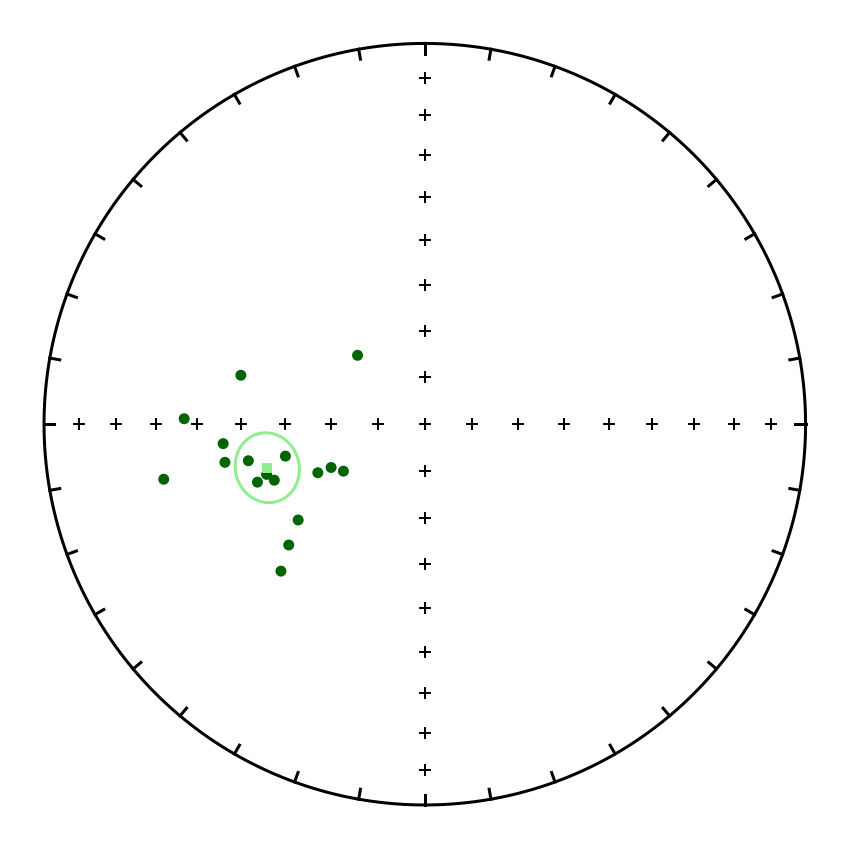

In [93]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Greenstone_sites['dir_dec'].tolist(), Greenstone_sites['dir_inc'].tolist(), color = 'darkgreen')

ipmag.plot_di_mean(Greenstone_sites_dir_mean['dec'],Greenstone_sites_dir_mean['inc'],Greenstone_sites_dir_mean['alpha95'],
                   color='lightgreen', marker = 's')

# plt.savefig('mc_site_mean_directions.pdf')
plt.show()

In [94]:
Greenstone_sites_vgp_mean = ipmag.fisher_mean(Greenstone_sites['vgp_lon'].tolist(), Greenstone_sites['vgp_lat'].tolist())
Greenstone_sites_vgp_mean

{'dec': 217.76882407719347,
 'inc': 16.99780316608527,
 'n': 17,
 'r': 16.06739392419096,
 'k': 17.15622535068723,
 'alpha95': 8.867163489226282,
 'csd': 19.555735193580546}

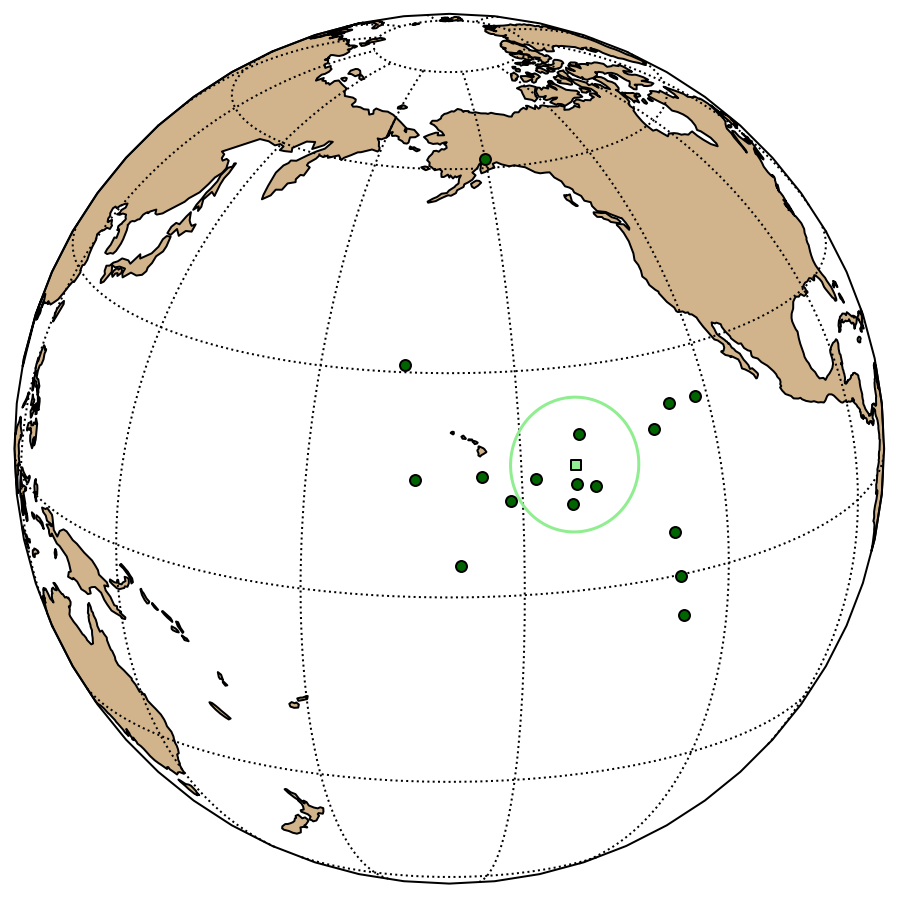

In [95]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_vgp(map_axis, Greenstone_sites['vgp_lon'].tolist(), Greenstone_sites['vgp_lat'].tolist(), 
               color = 'darkgreen', markersize = 30)
ipmag.plot_pole(map_axis, Greenstone_sites_vgp_mean['dec'],Greenstone_sites_vgp_mean['inc'], Greenstone_sites_vgp_mean['alpha95'], 
                color = 'lightgreen', marker = 's', markersize = 30)

plt.show()

**tilt correct the Greenstone Flows:**

In [96]:
Greenstone_sites['dec_tc'] = [pmag.dotilt(Greenstone_sites['dir_dec'].tolist()[i], Greenstone_sites['dir_inc'].tolist()[i], 
                                          Greenstone_sites['dip_trend'].tolist()[i],  Greenstone_sites['dip'].tolist()[i])[0]
                                      for i in range(len(Greenstone_sites['dir_dec']))]
Greenstone_sites['inc_tc'] = [pmag.dotilt(Greenstone_sites['dir_dec'].tolist()[i], Greenstone_sites['dir_inc'].tolist()[i], 
                                          Greenstone_sites['dip_trend'].tolist()[i],  Greenstone_sites['dip'].tolist()[i])[1] 
                                      for i in range(len(Greenstone_sites['dir_dec']))]


In [97]:
Greenstone_sites_tc = ipmag.vgp_calc(Greenstone_sites,  tilt_correction='no',
    site_lon='lon',
    site_lat='lat',
    dec_is='dec_tc',
    inc_is='inc_tc')
Greenstone_sites.head()

site location  dir_dec  dir_inc      dec_tc     inc_tc  dir_k  \
34  GS03  Phoenix    240.0     69.9  289.723420  58.610159     69   
35  GS04  Phoenix    245.6     64.8  285.243376  53.670237     71   
36  GS02  Phoenix    232.9     55.7  267.417795  51.467585    285   
37  GS05  Phoenix    250.9     51.6  275.970768  41.692656     66   
38  GS06  Phoenix    245.2     67.9  288.987899  55.901529     64   

    dir_n_samples  dir_n_specimens  dir_n_total_specimens  ...  \
34              5                8                      8  ...   
35              5                8                      8  ...   
36              6               10                     10  ...   
37              5               10                     10  ...   
38              5                9                      9  ...   

           citations   description  dip_trend  dip width(m) paleolatitude  \
34  FoucherPhDthesis  upper ophite        151  -25      NaN     39.333186   
35  FoucherPhDthesis  upper ophite        151  -25      NaN     34.212840   
36  FoucherPhDthesis  upper ophite        151  -25      NaN     32.122933   
37  FoucherPhDthesis  upper ophite        151  -25      NaN     24.006700   
38  FoucherPhDthesis  upper ophite        151  -25      NaN     36.447327   

      vgp_lat     vgp_lon vgp_lat_rev vgp_lon_rev  
34  40.033351  199.739192  -40.033351   19.739192  
35  34.127819  197.169652  -34.127819   17.169652  
36  21.441438  206.361447  -21.441438   26.361447  
37  21.332787  194.458401  -21.332787   14.458401  
38  37.911912  197.114796  -37.911912   17.114796  

[5 rows x 32 columns]

In [98]:
Greenstone_sites_dir_mean_tc = ipmag.fisher_mean(Greenstone_sites_tc['dec_tc'].tolist(), Greenstone_sites_tc['inc_tc'].tolist())
Greenstone_sites_dir_mean_tc

{'dec': 284.20767955237557,
 'inc': 47.09286740870868,
 'n': 17,
 'r': 16.463970049767628,
 'k': 29.849078382773033,
 'alpha95': 6.638118296972671,
 'csd': 14.825848423181792}

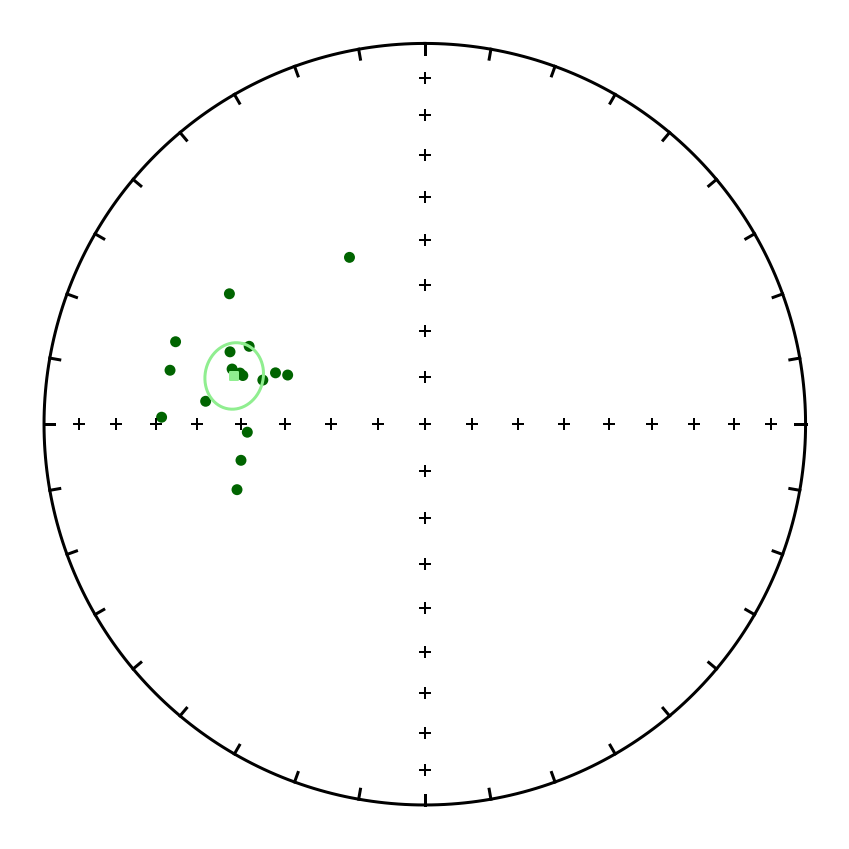

In [99]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(Greenstone_sites_tc['dec_tc'].tolist(), Greenstone_sites_tc['inc_tc'].tolist(), color = 'darkgreen')

ipmag.plot_di_mean(Greenstone_sites_dir_mean_tc['dec'],Greenstone_sites_dir_mean_tc['inc'],Greenstone_sites_dir_mean_tc['alpha95'],
                   color='lightgreen', marker = 's')

# plt.savefig('code_output/pmag/GSF_site_mean_directions.pdf')
plt.show()

In [100]:
Greenstone_sites_tc_vgp_mean = ipmag.fisher_mean(Greenstone_sites_tc['vgp_lon'].tolist(), Greenstone_sites_tc['vgp_lat'].tolist())
Greenstone_sites_tc_vgp_mean

{'dec': 192.9340013775176,
 'inc': 30.113201710929257,
 'n': 17,
 'r': 16.277108215831074,
 'k': 22.133326661603206,
 'alpha95': 7.7545099087872,
 'csd': 17.217166208344803}

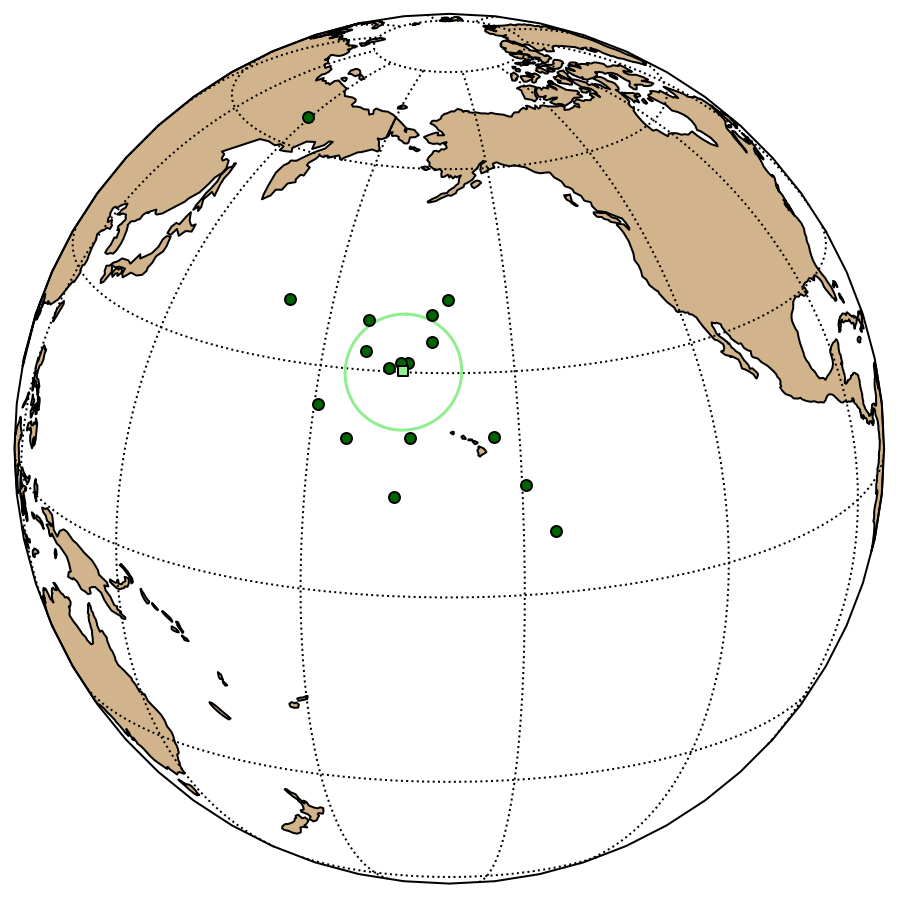

In [101]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=20)

ipmag.plot_vgp(map_axis, Greenstone_sites_tc['vgp_lon'].tolist(), Greenstone_sites_tc['vgp_lat'].tolist(), 
               color = 'darkgreen', markersize = 30)
ipmag.plot_pole(map_axis, Greenstone_sites_tc_vgp_mean['dec'],Greenstone_sites_tc_vgp_mean['inc'], Greenstone_sites_tc_vgp_mean['alpha95'], 
                color = 'lightgreen', marker = 's', markersize = 30)

plt.show()

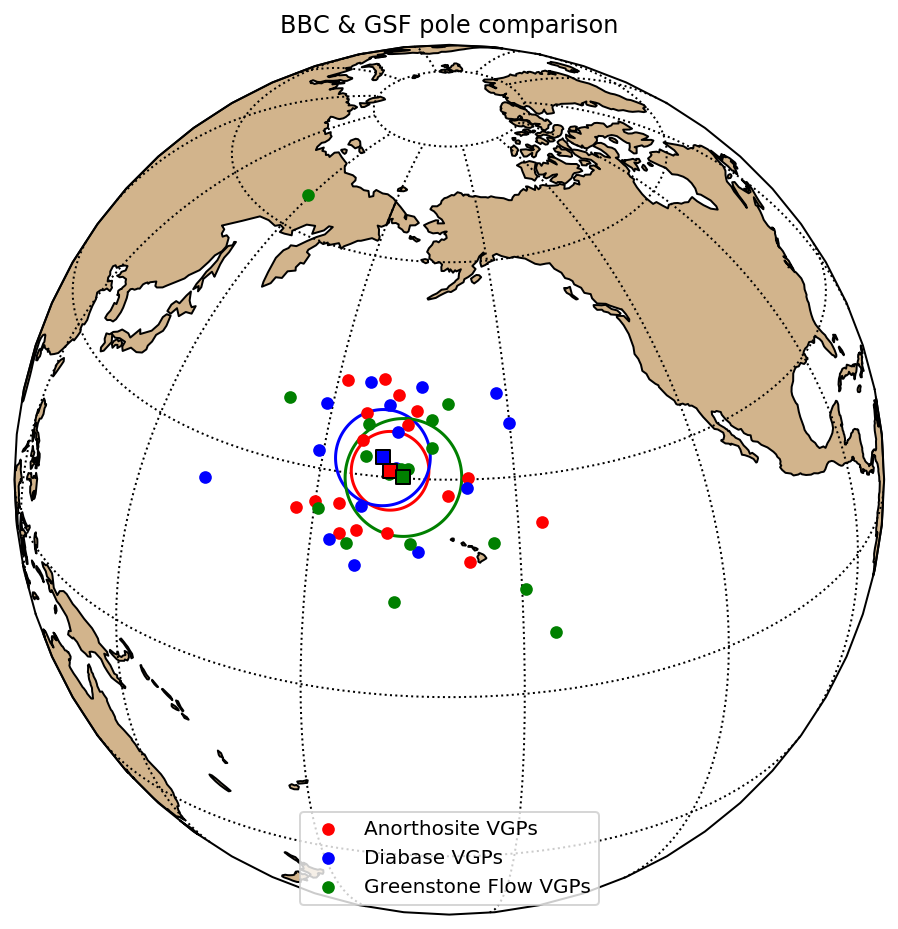

In [102]:
map_axis = ipmag.make_orthographic_map(central_longitude=200,central_latitude=30)


ipmag.plot_vgp(map_axis, AX_site_mct_tc['vgp_lon'].tolist(), AX_site_mct_tc['vgp_lat'].tolist(), 
               color = 'red', label = 'Anorthosite VGPs', markersize = 40, edge = 'none')
ipmag.plot_vgp(map_axis, BD_site_mct_tc['vgp_lon'].tolist(), BD_site_mct_tc['vgp_lat'].tolist(), 
               color = 'blue', label = 'Diabase VGPs', markersize = 40, edge = 'none')
ipmag.plot_vgp(map_axis, Greenstone_sites_tc['vgp_lon'].tolist(), Greenstone_sites_tc['vgp_lat'].tolist(), 
               color = 'green', label = 'Greenstone Flow VGPs', markersize = 40, edge = 'none')

ipmag.plot_pole(map_axis, AX_site_vgp_tc_mean['dec'], AX_site_vgp_tc_mean['inc'], AX_site_vgp_tc_mean['alpha95'], 
                color = 'red', marker = 's', markersize = 45)
ipmag.plot_pole(map_axis, BD_site_vgp_tc_mean['dec'], BD_site_vgp_tc_mean['inc'], BD_site_vgp_tc_mean['alpha95'], 
                color = 'blue', marker = 's', markersize = 45)
ipmag.plot_pole(map_axis, Greenstone_sites_tc_vgp_mean['dec'],Greenstone_sites_tc_vgp_mean['inc'], Greenstone_sites_tc_vgp_mean['alpha95'], 
                color = 'green', marker = 's', markersize = 45)

plt.title('BBC & GSF pole comparison')
plt.legend(loc = 8)
# plt.savefig('code_output/pmag/BRD_AX_GSF_VGP.pdf')
plt.show()

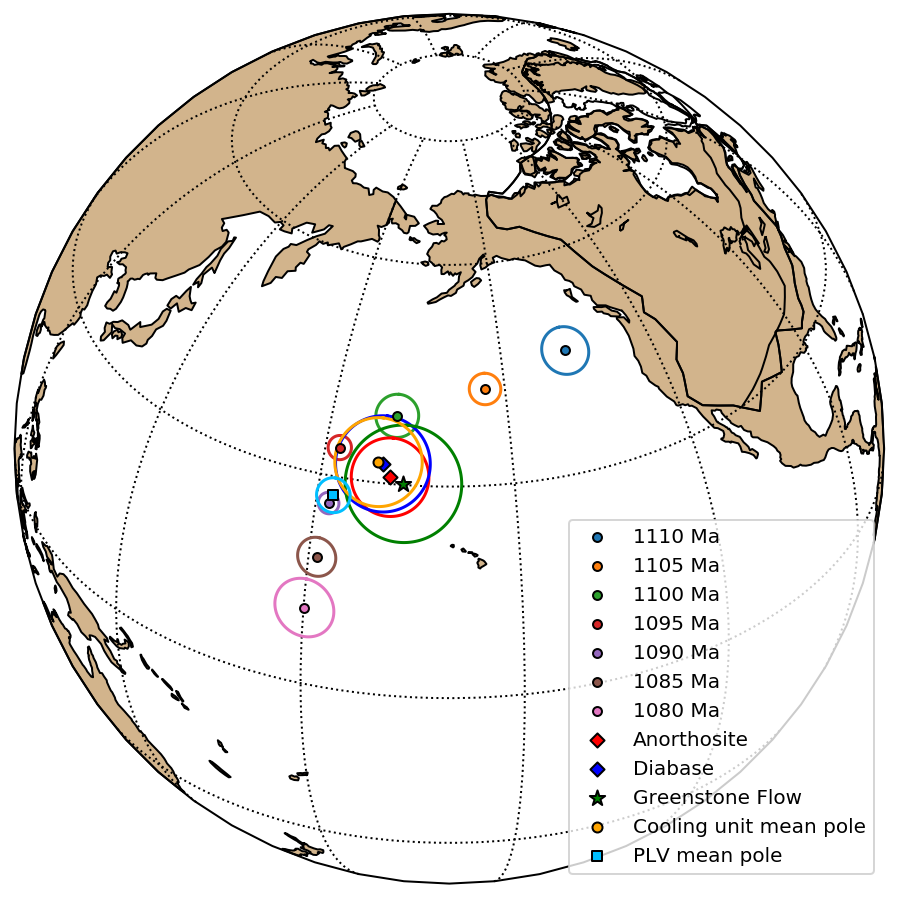

In [103]:
one_Euler_pole_lon = np.loadtxt('../Data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../Data/mcplates_results/pole_lat_positions_2_true.txt')

m = ipmag.make_orthographic_map(central_latitude=35,central_longitude=200)
m.add_feature(Laurentia_outline)
plt.figure(num=1,figsize=(10, 10))

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color='C0',label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color='C1',label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color='C2',label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color='C3',label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color='C4',label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color='C5',label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color='C6',label='1080 Ma')

ipmag.plot_pole(m, AX_site_vgp_tc_mean['dec'], AX_site_vgp_tc_mean['inc'], AX_site_vgp_tc_mean['alpha95'], 
                marker = 'D', markersize = 25, color = 'red', label = 'Anorthosite')
ipmag.plot_pole(m, BD_site_vgp_tc_mean['dec'], BD_site_vgp_tc_mean['inc'], BD_site_vgp_tc_mean['alpha95'], 
                marker = 'D', markersize = 25, color = 'blue', label = 'Diabase')

ipmag.plot_pole(m, Greenstone_sites_tc_vgp_mean['dec'],Greenstone_sites_tc_vgp_mean['inc'], Greenstone_sites_tc_vgp_mean['alpha95'], 
                color = 'green', marker = '*', markersize = 65, label = 'Greenstone Flow')
ipmag.plot_pole(m, CU_pole_mean['dec'], CU_pole_mean['inc'], CU_pole_mean['alpha95'], 
                marker = 'o', markersize = 25, color = 'orange', label = 'Cooling unit mean pole')
ipmag.plot_pole(m, 182.5, 27.5, 2.3, marker = 's', markersize = 25, color = 'deepskyblue', label = 'PLV mean pole')
# plt.title('BBC & GSF pole comparison')
plt.legend(loc = 4)
# plt.savefig('code_output/pmag/BRD_AX_GSF_PLV_Keew_2e_true.pdf')


plt.show()

## Common mean test between the GSF and BRD and AX paleomagnetic pole positions

In [104]:
# site common mean test
All_GSF_blocks = ipmag.make_di_block(Greenstone_sites_tc['dec_tc'].tolist(), Greenstone_sites_tc['inc_tc'].tolist())

In [105]:
ipmag.common_mean_watson(All_AX_blocks, All_GSF_blocks)

Results of Watson V test: 

Watson's V:           0.1
Critical value of V:  6.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.1
Critical angle for M&M1990:   8.0
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 1.0815301658689478, 8.033694879191463)

In [106]:
ipmag.common_mean_watson(All_GSF_blocks, All_BD_blocks)

Results of Watson V test: 

Watson's V:           0.3
Critical value of V:  6.4
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.9
Critical angle for M&M1990:   9.5
The McFadden and McElhinny (1990) classification for
this test is: 'B'


(1, 1.9313347462508264, 9.529346563998109)